# Challenge Multi-Class : Skin Lesion Classification Using Machine Learning 
**Author(s):** Muhammad Imran Hossain, Enrique Franky Vargas
<br>**Institute:** University of Girona, Spain

# Necessary Libraries

In [2]:
#Import all the necessary libraries for the project
import os
import cv2
import time
import math
import pickle
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image, ImageEnhance
from matplotlib import pyplot as plt

import mahotas as mt

from scipy import ndimage
from scipy.stats import skew, kurtosis

from skimage import feature
from skimage.transform import rescale
from skimage.feature import graycomatrix, graycoprops, hog

from sklearn.utils import shuffle, resample
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, confusion_matrix, balanced_accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC


from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import StackingClassifier

import xgboost as xgb 

# Image Preprocessing Class

- **Image preprocessing is used to remove hair and crop the black vintage of the dermoscopy images.**

In [2]:
# Class for the image augmentation
class ImagePreprocessing:
    def __init__(self):
        pass
    

    def crop_img(self, img, threshold=100):

        # Get the image dimensions
        h, w = img.shape[:2]
        cd = math.gcd(h, w)  # Greatest Common Divider

        # Get the coordinates of the pixels in the diagonal
        y_coords = ([i for i in range(0, h, int(h/cd))], [i for i in range(h - int(h/cd), 0, -int(h/cd))])
        x_coords = ([i for i in range(0, w, int(w/cd))], [i for i in range(0, w, int(w/cd))])

        # Get the mean value of the pixels in the diagonal, form 0,0 to h,w 
        # and from h,0 to 0,w
        coordinates = {'y1_1': 0, 'x1_1': 0, 'y2_1': h, 'x2_1': w, 'y1_2': h, 'x1_2': 0, 'y2_2': 0, 'x2_2': w}
        for i in range(2):
            d = []
            y1_aux, x1_aux = 0, 0
            y2_aux, x2_aux = h, w 
            for y, x in zip(y_coords[i], x_coords[i]):
                d.append(np.mean(img[y, x, :]))

            # Get the location of the first point where the threshold is crossed
            for idx, value in enumerate(d):
                if (value >= threshold and idx != 0):  # If there's no vignette, in idx=0 the value would be > thresh..
                    coordinates['y1_' + str(i + 1)] = y_coords[i][idx]
                    coordinates['x1_' + str(i + 1)] = x_coords[i][idx]
                    break

            # Get the location of the last point where the threshold is crossed
            for idx, value in enumerate(reversed(d)):
                if (value >= threshold and idx != 0):  # If there's no vignette, in idx=0 the value would be > thresh..
                    coordinates['y2_' + str(i + 1)] = y_coords[i][len(y_coords[i])-idx]
                    coordinates['x2_' + str(i + 1)] = x_coords[i][len(x_coords[i])-idx]
                    break

        # Set the coordinates to crop the image
        y1 = max(coordinates['y1_1'], coordinates['y2_2'])
        y2 = min(coordinates['y2_1'], coordinates['y1_2'])
        x1 = max(coordinates['x1_1'], coordinates['x1_2'])
        x2 = min(coordinates['x2_1'], coordinates['x2_2'])

        img_new = img[y1:y2, x1:x2, :]

        if img_new.shape[0] == 0 or img_new.shape[1] == 0:
            img_new = img 

        return img_new  


    def inpaint(self, src, se_size = 15):    

        # Convert the original image to grayscale if it has > 1 channel
        if (len(src.shape)==3):
            channel = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
        else:
            channel = src

        # Structuring Element for the morphological filtering

        se = cv2.getStructuringElement(1, (se_size, se_size))  # (17x17) '+' shaped SE
        se2 = np.array(list(reversed(list(zip(*np.eye(se_size)))))) + np.eye(se_size)
        se2[int(se_size/2), int(se_size/2)] = 1  # (17x17) 'X' shaped SE

        # Perform the blackHat filtering on the grayscale image to find the 
        # hair (and other objects') countours
        blackhat = cv2.morphologyEx(channel, cv2.MORPH_BLACKHAT, se)
        blackhat2 = cv2.morphologyEx(channel, cv2.MORPH_BLACKHAT, se2.astype(np.uint8))
        bHat = blackhat + blackhat2

        # Intensify the countours detected in preparation for the inpainting algorithm
        ret, thresh = cv2.threshold(bHat, 10, 255, cv2.THRESH_BINARY)

        # Inpaint the original image depending on the mask
        Inp = cv2.inpaint(src, thresh, 1, cv2.INPAINT_TELEA)

        return Inp
    

    def shade_of_gray_cc(self, img, power=6, gamma=None):

        img_dtype = img.dtype

        if gamma is not None:
            img = img.astype('uint8')
            look_up_table = np.ones((256,1), dtype='uint8') * 0
            for i in range(256):
                look_up_table[i][0] = 255 * pow(i/255, 1/gamma)
            img = cv.LUT(img, look_up_table)

        img = img.astype('float32')
        img_power = np.power(img, power)
        rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
        rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
        rgb_vec = rgb_vec/rgb_norm
        rgb_vec = 1/(rgb_vec*np.sqrt(3))
        img = np.multiply(img, rgb_vec)

        img = np.clip(img, a_min=0, a_max=255)

        return img.astype(img_dtype)
    

    def preprocess(self, img, max_size, crop_params=None, cc_params=None, remove_hair_params=None):

        if crop_params is not None:
            img = self.crop_img(img, threshold=crop_params["threshold"])

        #img = resize_im(img, max_size)

        if cc_params is not None: 
            img = self.shade_of_gray_cc(img, power=cc_params["power"], gamma=cc_params["gamma"])

        if remove_hair_params is not None: 
            img = self.inpaint(img, se_size =  remove_hair_params['se_size'])

        return img
    

    def apply_preprocess(self, image):
        
        image = self.preprocess(image, 500, crop_params= {"threshold": 50}, cc_params={"gamma": None, "power":6}, remove_hair_params={'se_size': 9})
        
        return image
    

# Data Augmentation Class

- **Data augmentation is used to balance the dataset as the provided dataset is highly imbalanced**

In [15]:
# Class for the image augmentation
class ImageAugmentation:
    def __init__(self):
        pass

    @staticmethod
    # Function for the image cropping
    def crop_center(image):
        # Get dimensions of the image
        rows, cols, _ = image.shape

        # Calculate the radius for cropping
        crop_radius = min(rows, cols) * random.uniform(0.4, 0.9) / 2

        # Calculate the center of the image
        center_x, center_y = rows // 2, cols // 2

        # Calculate the starting and ending points for cropping
        start_x = max(0, int(center_x - crop_radius))
        end_x = min(rows, int(center_x + crop_radius))
        start_y = max(0, int(center_y - crop_radius))
        end_y = min(cols, int(center_y + crop_radius))

        # Perform the cropping
        cropped_image = image[start_x:end_x, start_y:end_y]

        # Return the cropped image array
        return cropped_image

    @staticmethod
    # Function for the image scaling 
    def scale_image(image):
        # Define the scale range for the random scaling factor
        scale_range = (0.5, 1.5)

        # Generate a random scaling factor within the defined scale range
        scaling_factor = random.uniform(scale_range[0], scale_range[1])

        # Perform the scaling operation
        scaled_image = cv2.resize(image, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)

        # Return the scaled image array
        return scaled_image
    
    # Function for the noisy image
    @staticmethod
    def noisy_image(image):
        # Randomly adjust brightness
        random_brightness = random.uniform(0.5, 1.5)
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        v = hsv[:, :, 2]
        hsv[:, :, 2] = np.uint8(np.clip(v * random_brightness, 0, 255))

        # Randomly adjust contrast
        random_contrast = random.uniform(0.5, 1.5)
        image = cv2.addWeighted(image, random_contrast, np.zeros(image.shape, image.dtype), 0, 0)

        # Add random noise
        noise = np.random.normal(scale=5, size=image.shape)
        noisy_image = cv2.add(image, noise, dtype=cv2.CV_8U)

        # Return the noisy image array
        return noisy_image

# Features Extraction Class

- **Feature extraction is used to extract features from the images for the machine learing classifier**

In [4]:
# Class for the image augmentation
class FeatureExtraction:
    def __init__(self):
        pass

    # Function for Gray Level Co-occurrence Matrix (GLCM) features
    @staticmethod
    def glcm_feature(image):

        # Extract the blue channel from the image
        blue_channel = image[:, :, 0]

        # Define GLCM properties
        distances = [1, 2, 3, 4, 5]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]

        # Initialize an empty dictionary to store GLCM features
        glcm_features = {}

        # Calculate GLCM for each distance and angle
        for d in distances:
            for angle in angles:
                glcm = graycomatrix(blue_channel, [d], [angle], levels=256, symmetric=True, normed=True)

                # Calculate GLCM properties
                contrast = graycoprops(glcm, 'contrast')[0, 0]
                dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
                homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
                energy = graycoprops(glcm, 'energy')[0, 0]
                correlation = graycoprops(glcm, 'correlation')[0, 0]
                entropy = -np.sum(glcm * np.log2(glcm + np.finfo(float).eps))

                # Store features in the dictionary
                glcm_features[f'Contrast_{d}_{angle*(180/math.pi)}'] = contrast
                glcm_features[f'Dissimilarity_{d}_{angle*(180/math.pi)}'] = dissimilarity
                glcm_features[f'Homogeneity_{d}_{angle*(180/math.pi)}'] = homogeneity
                glcm_features[f'Energy_{d}_{angle*(180/math.pi)}'] = energy
                glcm_features[f'Correlation_{d}_{angle*(180/math.pi)}'] = correlation
                glcm_features[f'Entropy_{d}_{angle*(180/math.pi)}'] = entropy

        # Create a Pandas DataFrame from the GLCM features
        df = pd.DataFrame([glcm_features])

        return df

    
    # Function for Intensity features
    @staticmethod
    def intensity_feature(image):
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Calculate intensity features
        mean_intensity = np.mean(gray_image)
        median_intensity = np.median(gray_image)
        std_dev_intensity = np.std(gray_image)
        min_intensity = np.min(gray_image)
        max_intensity = np.max(gray_image)
        skewness_intensity = skew(gray_image.flatten())
        kurtosis_intensity = kurtosis(gray_image.flatten())
        intensity_25th_percentile = np.percentile(gray_image, 25)
        intensity_75th_percentile = np.percentile(gray_image, 75)

        # Compute the intensity histogram
        histogram = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
        histogram_entropy = -np.sum(histogram * np.log2(histogram + np.finfo(float).eps))

        # Create a dictionary to store intensity features
        intensity_features = {
            'Mean_Intensity': mean_intensity,
            'Median_Intensity': median_intensity,
            'Std_Dev_Intensity': std_dev_intensity,
            'Min_Intensity': min_intensity,
            'Max_Intensity': max_intensity,
            'Skewness_Intensity': skewness_intensity,
            'Kurtosis_Intensity': kurtosis_intensity,
            'Intensity_25th_Percentile': intensity_25th_percentile,
            'Intensity_75th_Percentile': intensity_75th_percentile,
            'Histogram_Entropy': histogram_entropy
        }

        # Create a Pandas DataFrame from the intensity features
        df = pd.DataFrame([intensity_features])

        return df

    # Function for Color features
    @staticmethod
    def color_feature(image):
        # Convert the image to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Calculate color features
        mean_red = np.mean(image_rgb[:, :, 0])
        mean_green = np.mean(image_rgb[:, :, 1])
        mean_blue = np.mean(image_rgb[:, :, 2])

        std_dev_red = np.std(image_rgb[:, :, 0])
        std_dev_green = np.std(image_rgb[:, :, 1])
        std_dev_blue = np.std(image_rgb[:, :, 2])

        skewness_red = skew(image_rgb[:, :, 0].flatten())
        skewness_green = skew(image_rgb[:, :, 1].flatten())
        skewness_blue = skew(image_rgb[:, :, 2].flatten())

        min_red = np.min(image_rgb[:, :, 0])
        max_red = np.max(image_rgb[:, :, 0])
        min_green = np.min(image_rgb[:, :, 1])
        max_green = np.max(image_rgb[:, :, 1])
        min_blue = np.min(image_rgb[:, :, 2])
        max_blue = np.max(image_rgb[:, :, 2])

        variance_red = np.var(image_rgb[:, :, 0])
        variance_green = np.var(image_rgb[:, :, 1])
        variance_blue = np.var(image_rgb[:, :, 2])

        # Convert the image to HSV color space
        image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

        # Calculate HSV features
        mean_hue = np.mean(image_hsv[:, :, 0])
        mean_saturation = np.mean(image_hsv[:, :, 1])
        mean_value = np.mean(image_hsv[:, :, 2])

        std_dev_hue = np.std(image_hsv[:, :, 0])
        std_dev_saturation = np.std(image_hsv[:, :, 1])
        std_dev_value = np.std(image_hsv[:, :, 2])

        skewness_hue = skew(image_hsv[:, :, 0].flatten())
        skewness_saturation = skew(image_hsv[:, :, 1].flatten())
        skewness_value = skew(image_hsv[:, :, 2].flatten())

        min_hue = np.min(image_hsv[:, :, 0])
        max_hue = np.max(image_hsv[:, :, 0])
        min_saturation = np.min(image_hsv[:, :, 1])
        max_saturation = np.max(image_hsv[:, :, 1])
        min_value = np.min(image_hsv[:, :, 2])
        max_value = np.max(image_hsv[:, :, 2])

        variance_hue = np.var(image_hsv[:, :, 0])
        variance_saturation = np.var(image_hsv[:, :, 1])
        variance_value = np.var(image_hsv[:, :, 2])

        # Convert the image to LAB color space
        image_lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)

        # Calculate LAB features
        mean_l = np.mean(image_lab[:, :, 0])
        mean_a = np.mean(image_lab[:, :, 1])
        mean_b = np.mean(image_lab[:, :, 2])

        std_dev_l = np.std(image_lab[:, :, 0])
        std_dev_a = np.std(image_lab[:, :, 1])
        std_dev_b = np.std(image_lab[:, :, 2])

        skewness_l = skew(image_lab[:, :, 0].flatten())
        skewness_a = skew(image_lab[:, :, 1].flatten())
        skewness_b = skew(image_lab[:, :, 2].flatten())

        min_l = np.min(image_lab[:, :, 0])
        max_l = np.max(image_lab[:, :, 0])
        min_a = np.min(image_lab[:, :, 1])
        max_a = np.max(image_lab[:, :, 1])
        min_b = np.min(image_lab[:, :, 2])
        max_b = np.max(image_lab[:, :, 2])

        variance_l = np.var(image_lab[:, :, 0])
        variance_a = np.var(image_lab[:, :, 1])
        variance_b = np.var(image_lab[:, :, 2])

        # Calculate entropy for the grayscale image
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        histogram = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
        histogram /= histogram.sum()
        entropy = -np.sum(histogram * np.log2(histogram + np.finfo(float).eps))

        # Calculate normalized histograms for all color spaces
        histogram_rgb = {}
        histogram_hsv = {}
        histogram_lab = {}

        for channel in range(3):
            hist = cv2.calcHist([image_rgb], [channel], None, [256], [0, 256])
            hist /= hist.sum()
            flattened_hist = hist.flatten()
            histogram_rgb[f'Hist_R_{channel}'] = flattened_hist

        for channel in range(3):
            hist = cv2.calcHist([image_hsv], [channel], None, [256], [0, 256])
            hist /= hist.sum()
            flattened_hist = hist.flatten()
            histogram_hsv[f'Hist_H_{channel}'] = flattened_hist

        for channel in range(3):
            hist = cv2.calcHist([image_lab], [channel], None, [256], [0, 256])
            hist /= hist.sum()
            flattened_hist = hist.flatten()
            histogram_lab[f'Hist_L_{channel}'] = flattened_hist

        # Create a dictionary to store all features
        features = {
            'Mean_Red': mean_red,
            'Mean_Green': mean_green,
            'Mean_Blue': mean_blue,
            'Std_Dev_Red': std_dev_red,
            'Std_Dev_Green': std_dev_green,
            'Std_Dev_Blue': std_dev_blue,
            'Skewness_Red': skewness_red,
            'Skewness_Green': skewness_green,
            'Skewness_Blue': skewness_blue,
            'Min_Red': min_red,
            'Max_Red': max_red,
            'Min_Green': min_green,
            'Max_Green': max_green,
            'Min_Blue': min_blue,
            'Max_Blue': max_blue,
            'Variance_Red': variance_red,
            'Variance_Green': variance_green,
            'Variance_Blue': variance_blue,
            'Mean_Hue': mean_hue,
            'Mean_Saturation': mean_saturation,
            'Mean_Value': mean_value,
            'Std_Dev_Hue': std_dev_hue,
            'Std_Dev_Saturation': std_dev_saturation,
            'Std_Dev_Value': std_dev_value,
            'Skewness_Hue': skewness_hue,
            'Skewness_Saturation': skewness_saturation,
            'Skewness_Value': skewness_value,
            'Min_Hue': min_hue,
            'Max_Hue': max_hue,
            'Min_Saturation': min_saturation,
            'Max_Saturation': max_saturation,
            'Variance_Hue': variance_hue,
            'Variance_Saturation': variance_saturation,
            'Variance_Value': variance_value,
            'Mean_L': mean_l,
            'Mean_A': mean_a,
            'Mean_B': mean_b,
            'Std_Dev_L': std_dev_l,
            'Std_Dev_A': std_dev_a,
            'Std_Dev_B': std_dev_b,
            'Skewness_L': skewness_l,
            'Skewness_A': skewness_a,
            'Skewness_B': skewness_b,
            'Min_L': min_l,
            'Max_L': max_l,
            'Min_A': min_a,
            'Max_A': max_a,
            'Min_B': min_b,
            'Max_B': max_b,
            'Variance_L': variance_l,
            'Variance_A': variance_a,
            'Variance_B': variance_b,
            'Entropy': entropy
        }


        # Create a Pandas DataFrame from the features
        df = pd.DataFrame([features])

        return df

    @staticmethod
    def shape_feature(image):
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Threshold the image to create a binary mask of the lesion
        _, binary_mask = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

        # Find contours in the binary mask
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Initialize shape features as zeros
        shape_features = {
            'Perimeter': 0.0,
            'Area': 0.0,
            'Circularity': 0.0,
            'Compactness': 0.0,
            'Hue_Moment_1': 0.0,
            'Hue_Moment_2': 0.0
        }

        # Check if there are any contours
        if contours:
            # Find the contour with the maximum area (assumed to be the lesion)
            max_contour = max(contours, key=cv2.contourArea)

            # Calculate shape features
            shape_features['Perimeter'] = cv2.arcLength(max_contour, closed=True)
            shape_features['Area'] = cv2.contourArea(max_contour)

            # Handle division by zero for circularity
            perimeter = shape_features['Perimeter']
            area = shape_features['Area']
            if perimeter > 0:
                shape_features['Circularity'] = (4 * np.pi * area) / (perimeter * perimeter)

            # Calculate Compactness (Inverse of Circularity)
            if shape_features['Circularity'] > 0:
                shape_features['Compactness'] = 1 / shape_features['Circularity']

            # Calculate Hue Moments
            hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            hue_channel = hsv_image[:, :, 0]
            moments = cv2.moments(hue_channel)
            shape_features['Hue_Moment_1'] = moments['nu20']
            shape_features['Hue_Moment_2'] = moments['nu02']

        # Create a Pandas DataFrame from the features
        df = pd.DataFrame([shape_features])

        return df


    # Function for LBP features
    @staticmethod
    def lbp_feature(image):

        # Extract the blue channel from the image
        blue_channel_image = image[:, :, 0]

        radius = 1
        n_points = 8

        # Compute LBP features
        lbp_image = feature.local_binary_pattern(blue_channel_image, n_points, radius, method='uniform')

        # Calculate LBP histogram
        lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-8)

        # Create a dictionary to store LBP features
        lbp_features = {}
        for i, hist_value in enumerate(lbp_hist):
            lbp_features[f'LBP_Hist_{i}'] = hist_value

        # Create a Pandas DataFrame from the features
        df = pd.DataFrame([lbp_features])

        return df

    # Function for Haralick Texture Features
    @staticmethod
    def haralick_texture_feature(image):
        # Extract the blue channel from the image
        blue_channel_image = image[:, :, 0]

        # Compute Haralick Texture Features
        textures = mt.features.haralick(blue_channel_image)

        # Calculate the mean of each texture feature
        mean_textures = textures.mean(axis=0)

        # Create a dictionary to store Haralick Texture Features
        haralick_features = {}
        for i, feature in enumerate(mean_textures):
            haralick_features[f'Haralick_{i}'] = feature

        # Create a Pandas DataFrame from the features
        df = pd.DataFrame([haralick_features])

        return df

# Exploratory Data Analysis


In [5]:
# Define the path of the train and validation dataset directories
TRAIN_DATA_PATH = 'D:/Erasmus Mundus Masters/University of Girona/Computer Aided Diagnosis/Skin Lesion Classification Machine Learning/Multi_Class_Challenge/Dataset/train'
VALID_DATA_PATH = 'D:/Erasmus Mundus Masters/University of Girona/Computer Aided Diagnosis/Skin Lesion Classification Machine Learning/Multi_Class_Challenge/Dataset/val'
TEST_DATA_PATH  = 'D:/Erasmus Mundus Masters/University of Girona/Computer Aided Diagnosis/Skin Lesion Classification Machine Learning/Multi_Class_Challenge/Dataset/test'

# Define the path of the train bcc, train mel, and train scc dataset directories
train_bcc_data_path  = os.path.join(TRAIN_DATA_PATH, os.listdir(TRAIN_DATA_PATH)[0])
train_mel_data_path  = os.path.join(TRAIN_DATA_PATH, os.listdir(TRAIN_DATA_PATH)[1])
train_scc_data_path  = os.path.join(TRAIN_DATA_PATH, os.listdir(TRAIN_DATA_PATH)[2])

# Get the file names of the train bcc, train mel, and train scc dataset
train_bcc_files  = os.listdir(train_bcc_data_path)
train_mel_files  = os.listdir(train_mel_data_path)
train_scc_files  = os.listdir(train_scc_data_path)

# Define the path of the validation bcc, validation mel, and validation scc dataset directories
valid_bcc_data_path  = os.path.join(VALID_DATA_PATH, os.listdir(VALID_DATA_PATH)[0])
valid_mel_data_path  = os.path.join(VALID_DATA_PATH, os.listdir(VALID_DATA_PATH)[1])
valid_scc_data_path  = os.path.join(VALID_DATA_PATH, os.listdir(VALID_DATA_PATH)[2])

# Get the file names of the validation bcc, validation mel, and validation others dataset
valid_bcc_files  = os.listdir(valid_bcc_data_path)
valid_mel_files  = os.listdir(valid_mel_data_path)
valid_scc_files  = os.listdir(valid_scc_data_path)

# Define the path of the test dataset directories
test_data_path  = os.path.join(TEST_DATA_PATH)

# Get the file names of the test dataset
test_files  = os.listdir(test_data_path)


In [6]:
# Create a DataFrame for the train bcc, train mel, and train scc dataset
train_bcc_dataframe = pd.DataFrame({
    'FileName': train_bcc_files,
    'ImagePath': [os.path.join(train_bcc_data_path, filename) for filename in train_bcc_files],
    'Image': [np.array(Image.open(os.path.join(train_bcc_data_path, filename))) for filename in tqdm(train_bcc_files, desc="Image Reading Progressing")],
    'Label': 0
})

train_mel_dataframe = pd.DataFrame({
    'FileName': train_mel_files,
    'ImagePath': [os.path.join(train_mel_data_path, filename) for filename in train_mel_files],
    'Image': [np.array(Image.open(os.path.join(train_mel_data_path, filename))) for filename in tqdm(train_mel_files, desc="Image Reading Progressing")],
    'Label': 1
})

train_scc_dataframe = pd.DataFrame({
    'FileName': train_scc_files,
    'ImagePath': [os.path.join(train_scc_data_path, filename) for filename in train_scc_files],
    'Image': [np.array(Image.open(os.path.join(train_scc_data_path, filename))) for filename in tqdm(train_scc_files, desc="Image Reading Progressing")],
    'Label': 2
})

Image Reading Progressing: 100%|█████████████████████████████████████████████████████| 376/376 [00:17<00:00, 21.40it/s]


Total number of bcc in train data : 1993
Total number of mel in train data: 2713
Total number of scc in train data: 376


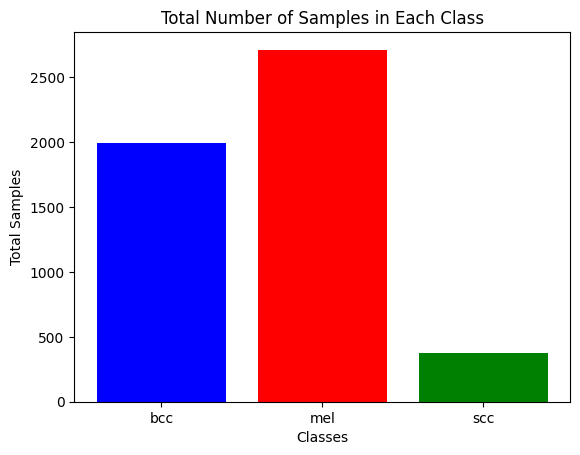

In [7]:
# Concatenate the bcc train, mel train, and scc train datafram 
train_dataframe = pd.concat([train_bcc_dataframe, train_mel_dataframe, train_scc_dataframe], axis=0)
train_dataframe = train_dataframe.sample(frac=1.0, random_state=42)
train_dataframe.reset_index(drop=True, inplace=True)

# Total number of bcc, mel, and others in train data
total_train_bcc  = (train_dataframe['Label'] == 0).sum()
total_train_mel  = (train_dataframe['Label'] == 1).sum()
total_train_scc  = (train_dataframe['Label'] == 2).sum()

print('Total number of bcc in train data :', total_train_bcc)
print('Total number of mel in train data:', total_train_mel)
print('Total number of scc in train data:', total_train_scc)

# Create a bar plot for visulization of the train dataset
labels = ['bcc', 'mel', 'scc']
totals = [total_train_bcc, total_train_mel, total_train_scc]

plt.bar(labels, totals, color=['blue', 'red', 'green'])
plt.xlabel('Classes')
plt.ylabel('Total Samples')
plt.title('Total Number of Samples in Each Class')
plt.show()


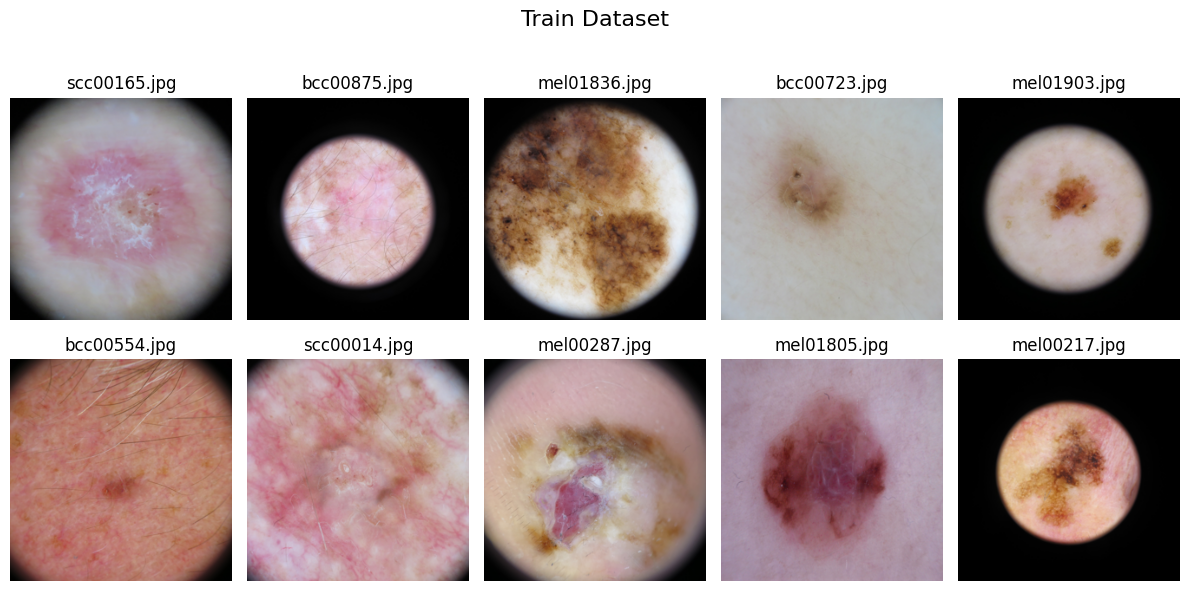

In [8]:
# Define the size of the image 
HEIGHT = 256
WIDTH  = 256

# Randomly select 10 rows from the train_dataframe
selected_train_images = train_dataframe.sample(n=10, random_state=42) 

# Plot randomly selected images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, (index, row) in enumerate(selected_train_images.iterrows()):
    ax = axes[i // 5, i % 5]
    
    # Read the image using PIL
    image = Image.open(row['ImagePath']).resize((HEIGHT,WIDTH))
    
    ax.imshow(image)  
    ax.set_title(row['FileName'])  
    ax.axis('off')

plt.suptitle("Train Dataset", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [9]:
# Create a DataFrame for the validation bcc, validation mel, and validation scc dataset
valid_bcc_dataframe = pd.DataFrame({
    'FileName': valid_bcc_files,
    'ImagePath': [os.path.join(valid_bcc_data_path, filename) for filename in valid_bcc_files],
    'Label': 0
})

valid_mel_dataframe = pd.DataFrame({
    'FileName': valid_mel_files,
    'ImagePath': [os.path.join(valid_mel_data_path, filename) for filename in valid_mel_files],
    'Label': 1  
})

valid_scc_dataframe = pd.DataFrame({
    'FileName': valid_scc_files,
    'ImagePath': [os.path.join(valid_scc_data_path, filename) for filename in valid_scc_files],
    'Label': 2 
})

Total number of bcc in validaiton data : 498
Total number of mel in validation data : 678
Total number of scc in validation data : 94


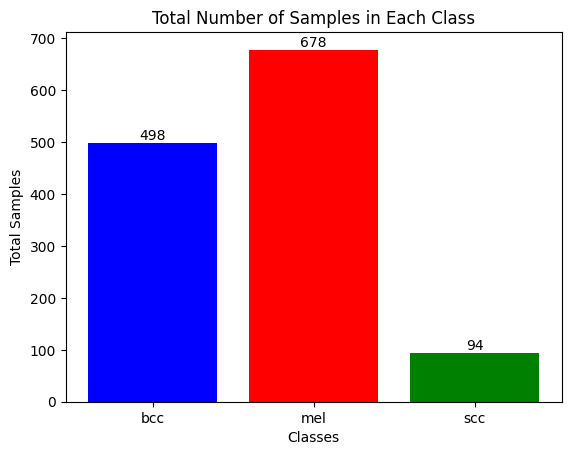

In [10]:
# Concatenate the validation bcc, validation mel, and validation scc datafram 
valid_dataframe = pd.concat([valid_bcc_dataframe, valid_mel_dataframe, valid_scc_dataframe], axis=0)
valid_dataframe = valid_dataframe.sample(frac=1.0, random_state=42)
valid_dataframe.reset_index(drop=True, inplace=True)

# Total number of bcc, mel, and scc in validation data
total_valid_bcc  = (valid_dataframe['Label'] == 0).sum()
total_valid_mel  = (valid_dataframe['Label'] == 1).sum()
total_valid_scc  = (valid_dataframe['Label'] == 2).sum()
print('Total number of bcc in validaiton data :', total_valid_bcc)
print('Total number of mel in validation data :', total_valid_mel)
print('Total number of scc in validation data :', total_valid_scc)

# Create a bar plot for visulization of the validation dataset
labels = ['bcc', 'mel', 'scc']
totals = [total_valid_bcc, total_valid_mel, total_valid_scc]

# Display the values on top of each bar
for i in range(len(labels)):
    plt.text(i, totals[i], str(totals[i]), ha='center', va='bottom')

plt.bar(labels, totals, color=['blue', 'red', 'green'])
plt.xlabel('Classes')
plt.ylabel('Total Samples')
plt.title('Total Number of Samples in Each Class')
plt.show()

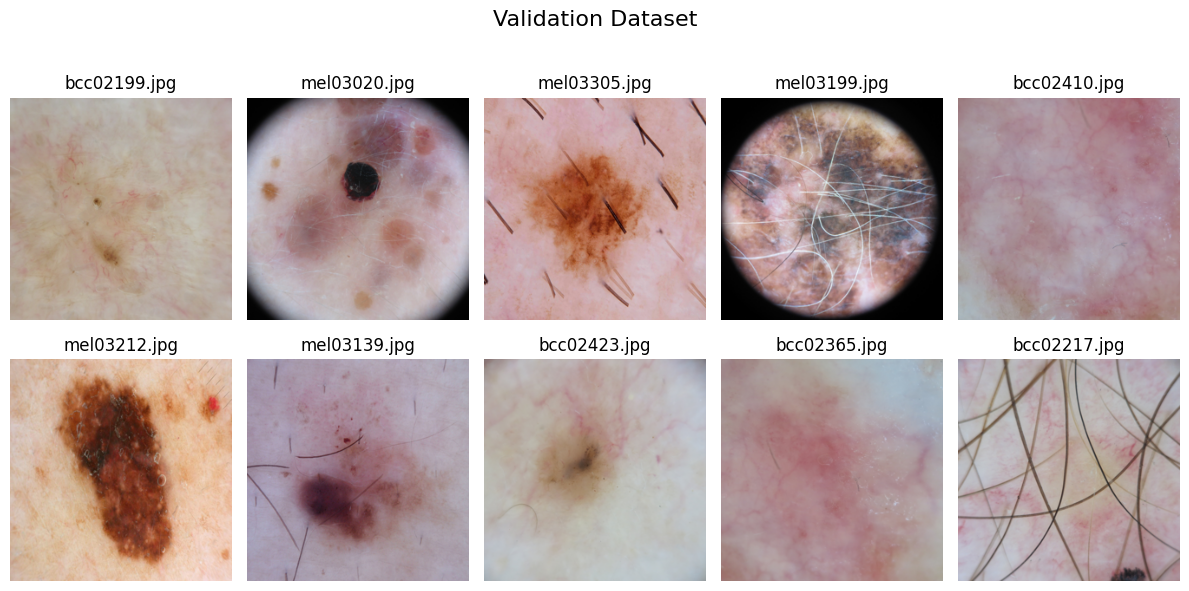

In [11]:
# Randomly select 10 rows from the validation dataframe
selected_valid_images = valid_dataframe.sample(n=10, random_state=42)  # Set a random seed for reproducibility

# Plot randomly selected images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, (index, row) in enumerate(selected_valid_images.iterrows()):
    ax = axes[i // 5, i % 5]
    
    # Read the image using PIL
    image = Image.open(row['ImagePath']).resize((HEIGHT,WIDTH))
    
    ax.imshow(image)  
    ax.set_title(row['FileName'])  
    ax.axis('off')

plt.suptitle("Validation Dataset", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [13]:
# Create a DataFrame for the test dataset
test_dataframe = pd.DataFrame({
    'FileName': test_files,
    'ImagePath': [os.path.join(test_data_path, filename) for filename in test_files],
})

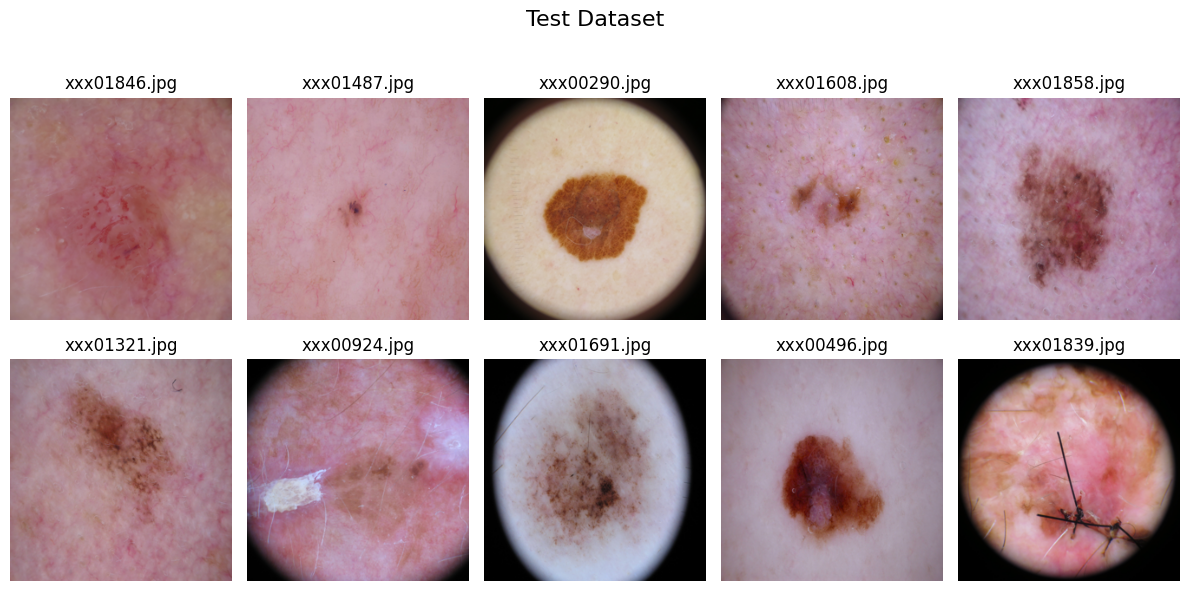

In [14]:
# Randomly select 10 rows from the validation dataframe
selected_test_images = test_dataframe.sample(n=10, random_state=42)  

# Plot randomly selected images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, (index, row) in enumerate(selected_test_images.iterrows()):
    ax = axes[i // 5, i % 5]
    
    # Read the image using PIL
    image = Image.open(row['ImagePath']).resize((HEIGHT,WIDTH))
    
    ax.imshow(image)  
    ax.set_title(row['FileName'])  
    ax.axis('off')

plt.suptitle("Test Dataset", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Data Augmentation

In [16]:
# Define lists for storing augmented data
augmented_bcc_data = []
augmented_scc_data = []

# Data augmentation for bcc class
random_bcc_data = train_dataframe[train_dataframe['Label'] == 0].sample(n=170, random_state=42)

for image_path in tqdm(random_bcc_data['ImagePath'], desc="Data Augmentation Progressing"):
    # Read the image
    image = Image.open(image_path)
    image = np.array(image)

    # Perform Augmentation on the bcc class
    augmentor = ImageAugmentation()
    croped_image = augmentor.crop_center(image)
    scaled_image  = augmentor.scale_image(image)
    noisy_image   = augmentor.noisy_image(image)
    #color_jittered_image  = augmentor.color_jitter(image, brightness=1.2, contrast=1.5, saturation=1.2, hue=20)


    
    # Extract the file name from the image path
    file_name = os.path.basename(image_path)

    # Append the data to the augmented_data list
    augmented_bcc_data.append({'FileName': 'aug_'+file_name, 'ImagePath': image_path ,'Image': croped_image, 'Label': 0})
    augmented_bcc_data.append({'FileName': 'aug_'+file_name, 'ImagePath': image_path ,'Image': scaled_image, 'Label': 0})
    augmented_bcc_data.append({'FileName': 'aug_'+file_name, 'ImagePath': image_path ,'Image': noisy_image, 'Label': 0})
    #augmented_bcc_data.append({'FileName': 'aug_'+file_name, 'ImagePath': image_path ,'Image': color_jittered_image, 'Label': 0})
    

# Create the augmented_train_dataframe
augmented_train_bcc_dataframe = pd.DataFrame(augmented_bcc_data)


# Data augmentation for scc class
random_scc_data = train_dataframe[train_dataframe['Label'] == 2].sample(n=300, random_state=42)

for image_path in tqdm(random_scc_data['ImagePath'], desc="Data Augmentation Progressing"):
    # Read the image
    image = Image.open(image_path)
    image = np.array(image)

    # Perform Augmentation on the bcc class
    augmentor = ImageAugmentation()
    croped_image = augmentor.crop_center(image)
    scaled_image  = augmentor.scale_image(image)
    noisy_image   = augmentor.noisy_image(image)
    #color_jittered_image  = augmentor.color_jitter(image, brightness=1.2, contrast=1.5, saturation=1.2, hue=20)


    # Extract the file name from the image path
    file_name = os.path.basename(image_path)

    # Append the data to the augmented_data list
    augmented_scc_data.append({'FileName': 'aug_'+file_name, 'ImagePath': image_path, 'Image': croped_image, 'Label': 2})
    augmented_scc_data.append({'FileName': 'aug_'+file_name, 'ImagePath': image_path, 'Image': scaled_image, 'Label': 2})
    augmented_scc_data.append({'FileName': 'aug_'+file_name, 'ImagePath': image_path, 'Image': noisy_image, 'Label': 2})
    #augmented_scc_data.append({'FileName': 'aug_'+file_name, 'ImagePath': image_path, 'Image': color_jittered_image, 'Label': 2})


# Create the augmented_train_dataframe
augmented_train_scc_dataframe = pd.DataFrame(augmented_scc_data)

# Concatenate the two dataframes horizontally
augmented_train_dataframe = pd.concat([augmented_train_bcc_dataframe, augmented_train_scc_dataframe], axis=0)

# Concatenate the two dataframes
combined_training_dataframe = pd.concat([train_dataframe, augmented_train_dataframe], axis=0)

# Shuffle the combined dataframe to introduce randomness
combined_training_dataframe = shuffle(combined_training_dataframe)

Data Augmentation Progressing: 100%|█████████████████████████████████████████████████| 300/300 [01:30<00:00,  3.30it/s]


Total number of bcc in train data after augmentation : 2503
Total number of mel in train data after augmentation : 2713
Total number of scc in train data after augmentation : 1276


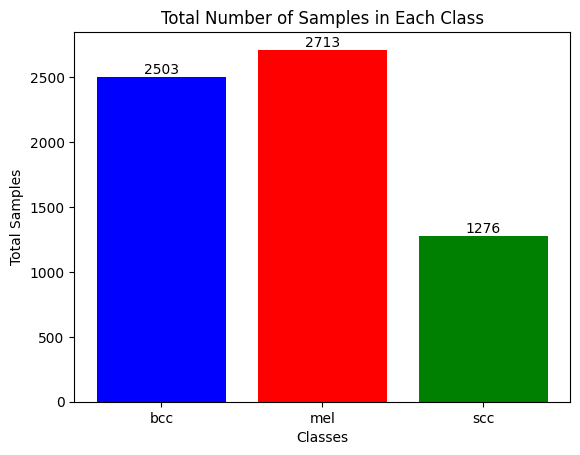

In [17]:
# Total number of bcc, mel, and scc in validation data
total_aug_train_bcc  = (combined_training_dataframe['Label'] == 0).sum()
total_aug_train_mel  = (combined_training_dataframe['Label'] == 1).sum()
total_aug_train_scc  = (combined_training_dataframe['Label'] == 2).sum()
print('Total number of bcc in train data after augmentation :', total_aug_train_bcc)
print('Total number of mel in train data after augmentation :', total_aug_train_mel)
print('Total number of scc in train data after augmentation :', total_aug_train_scc)

# Create a bar plot for visulization of the validation dataset
labels = ['bcc', 'mel', 'scc']
totals = [total_aug_train_bcc, total_aug_train_mel, total_aug_train_scc]

# Display the values on top of each bar
for i in range(len(labels)):
    plt.text(i, totals[i], str(totals[i]), ha='center', va='bottom')

plt.bar(labels, totals, color=['blue', 'red', 'green'])
plt.xlabel('Classes')
plt.ylabel('Total Samples')
plt.title('Total Number of Samples in Each Class')
plt.show()

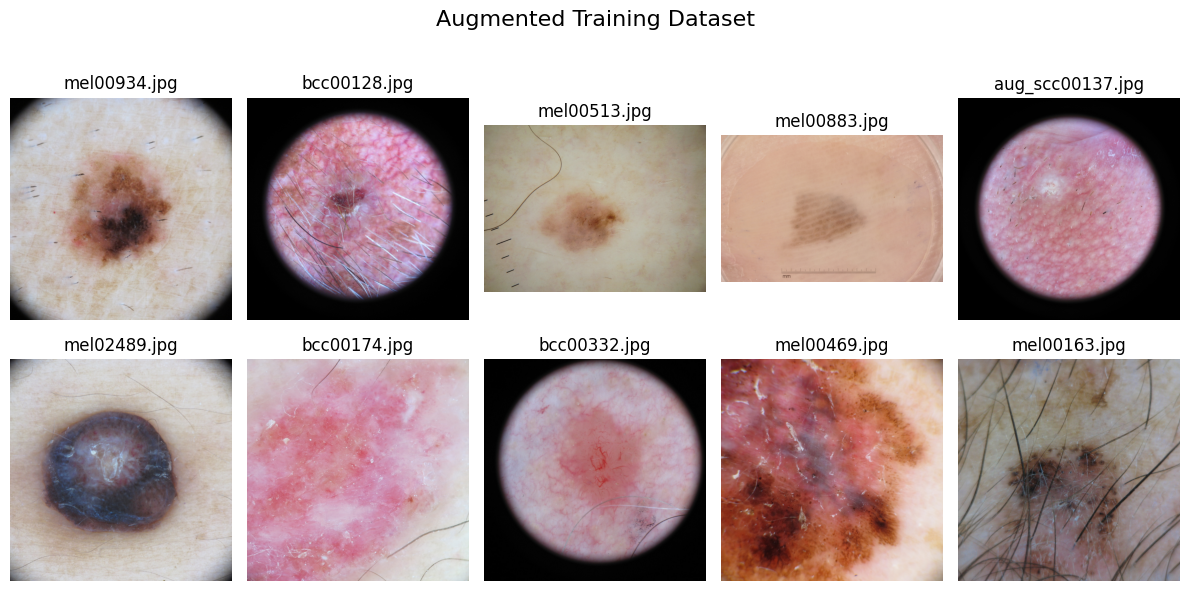

In [18]:
# Randomly select 10 rows from the train_dataframe
selected_augmented_images = augmented_train_dataframe.sample(n=10, random_state=1)  # Set a random seed for reproducibility

# Plot randomly selected images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, (index, row) in enumerate(selected_augmented_images.iterrows()):
    ax = axes[i // 5, i % 5]
    
    # Use the image from the 'Image' column directly
    image = row['Image']
    
    ax.imshow(image)  
    ax.set_title(row['FileName'])  
    ax.axis('off')

plt.suptitle("Augmented Training Dataset", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Feature Extraction

In [17]:
# Initialize empty lists to store the results
train_glcm_results_list      = []
train_intensity_results_list = []
train_color_results_list     = []
train_shape_results_list     = []
train_lbp_results_list       = []
train_haralick_results_list  = []
train_file_name_list         = []
train_label_list             = []

# Iterate through the rows of the DataFrame
for index, row in tqdm(combined_training_dataframe.iterrows(), total=combined_training_dataframe.shape[0], desc="Train Features Extraction Progressing"):

    image = row['Image']
    file_name = row['FileName']
    label = row['Label']
    
    # Apply pre-processing on the train image
    pre_processor = ImagePreprocessing()
    image         = pre_processor.apply_preprocess(image)
    
    # Create the class object for the feature extraction
    feature_extractor = FeatureExtraction()
        
    # Extract features using your feature extraction functions
    glcm_results      = feature_extractor.glcm_feature(image)
    intensity_results = feature_extractor.intensity_feature(image)
    color_results     = feature_extractor.color_feature(image)
    shape_results     = feature_extractor.shape_feature(image)
    lbp_results       = feature_extractor.lbp_feature(image)
    haralick_results  = feature_extractor.haralick_texture_feature(image)

    # Append the results to the corresponding lists
    train_glcm_results_list.append(glcm_results)
    train_intensity_results_list.append(intensity_results)
    train_color_results_list.append(color_results)
    train_shape_results_list.append(shape_results)
    train_lbp_results_list.append(lbp_results)
    train_haralick_results_list.append(haralick_results)

    # Append file name to the lists
    train_file_name_list.append(file_name)
    
    # Append label to the lists
    train_label_list.append(label)

Train Features Extraction Progressing: 100%|█████████████████████████████████████| 7786/7786 [3:54:49<00:00,  1.81s/it]


In [18]:
# Concatenate the results into DataFrames
train_glcm_features_dataframe      = pd.concat(train_glcm_results_list,ignore_index=True)
train_intensity_features_dataframe = pd.concat(train_intensity_results_list, ignore_index=True)
train_color_features_dataframe     = pd.concat(train_color_results_list, ignore_index=True)
train_shape_features_dataframe     = pd.concat(train_shape_results_list, ignore_index=True)
train_lbp_features_dataframe       = pd.concat(train_lbp_results_list, ignore_index=True)
train_haralick_features_dataframe  = pd.concat(train_haralick_results_list, ignore_index=True)
train_file_name_datafram           = pd.DataFrame(train_file_name_list)
train_label_dataframe              = pd.DataFrame(train_label_list, columns=['Label'])


# Combine all feature DataFrames into one DataFrame
train_features = pd.concat(
    [train_glcm_features_dataframe, train_intensity_features_dataframe, train_color_features_dataframe, 
     train_shape_features_dataframe, train_lbp_features_dataframe, train_haralick_features_dataframe], axis=1  
)


# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the train_features DataFrame
train_features_normalized = scaler.fit_transform(train_features)

# Convert the normalized array back to a DataFrame (optional)
train_features_normalized_df = pd.DataFrame(train_features_normalized, columns=train_features.columns)

train_features = pd.concat(
    [train_file_name_datafram, train_features_normalized_df, train_label_dataframe],
    axis=1  # Concatenate along columns
)

train_features.to_csv('train_features.csv', index=False)

train_features

0  Contrast_1_0.0  Dissimilarity_1_0.0  \
0     aug_scc00145.jpg       -0.528907            -0.798220   
1         mel02154.jpg        0.190505             0.614130   
2         bcc00396.jpg       -0.548114            -0.891610   
3         mel01338.jpg        0.175354             0.117946   
4     aug_bcc01397.jpg       -0.552729            -0.894061   
...                ...             ...                  ...   
7781      mel01834.jpg        1.310874             0.145222   
7782  aug_scc00203.jpg       -0.363642            -0.271874   
7783  aug_bcc01897.jpg        1.161532             2.326027   
7784  aug_scc00135.jpg        0.025950             0.267056   
7785  aug_scc00151.jpg        1.574270             2.862603   

      Homogeneity_1_0.0  Energy_1_0.0  Correlation_1_0.0  Entropy_1_0.0  \
0              0.791917      0.075895           0.143683      -1.164058   
1             -1.003148     -0.711945           0.068738       1.168718   
2              1.071293      0.183406           0.035034      -1.426755   
3             -0.429717      0.015235          -0.643654      -0.767423   
4              1.033179      0.253662          -0.155209      -1.648183   
...                 ...           ...                ...            ...   
7781           1.673955      3.969470           0.316086      -1.783471   
7782          -0.162444     -0.177654           0.028099      -0.453994   
7783          -1.990633     -0.410248           0.181712       0.863996   
7784          -0.428838     -0.326440          -0.037189       0.209054   
7785          -2.316306     -0.572603          -9.552182       0.415741   

      Contrast_1_45.0  Dissimilarity_1_45.0  Homogeneity_1_45.0  ...  \
0           -0.529769             -0.862251            0.738342  ...   
1            0.200612              0.723961           -1.024274  ...   
2           -0.553114             -1.007065            1.186654  ...   
3            0.173008              0.100229           -0.437116  ...   
4           -0.562773             -1.026221            1.165247  ...   
...               ...                   ...                 ...  ...   
7781         1.256133              0.221348            1.943087  ...   
7782        -0.332735             -0.195144           -0.329542  ...   
7783         0.603821              1.840054           -1.708991  ...   
7784         0.293135              0.578975           -0.688999  ...   
7785         0.953994              2.413644           -2.065496  ...   

      Haralick_4  Haralick_5  Haralick_6  Haralick_7  Haralick_8  Haralick_9  \
0       0.781270    0.469534   -0.788685   -1.040937   -1.157029    1.099292   
1      -1.014079   -0.156459   -0.620273    0.840416    1.178149   -1.027167   
2       1.137357    0.074658   -0.802045   -1.264457   -1.443754    1.452399   
3      -0.392825   -0.152029   -0.761187   -1.488599   -0.804045   -0.376903   
4       1.066359    0.059734   -0.808043   -1.569671   -1.655253    2.217199   
...          ...         ...         ...         ...         ...         ...   
7781    1.807513   -2.288069    1.942923   -1.859157   -1.801753    1.184239   
7782   -0.242140    0.761240   -0.762780   -0.688906   -0.418545   -0.042575   
7783   -1.849601   -1.952688   -0.116564   -0.174951    0.766433   -1.136097   
7784   -0.522851    0.149932   -0.702267    0.065352    0.252316   -0.632232   
7785   -2.192075    0.114029   -0.805147   -1.347884    0.326110   -1.532123   

      Haralick_10  Haralick_11  Haralick_12  Label  
0       -1.153836    -0.104420     0.166825      2  
1        0.989897     0.533770     0.214297      1  
2       -1.375620    -0.236080     0.165438      0  
3        0.269380     1.798338    -0.994529      1  
4       -1.415946     0.027547     0.084717      0  
...           ...          ...          ...    ...  
7781    -0.277472    -0.619762     0.189532      1  
7782    -0.053938     0.672338     0.062199      2  
7783     1.979331     1.548292    -0.180008      0  
7784   

In [20]:
# Initialize empty lists to store the results
valid_glcm_results_list      = []
valid_intensity_results_list = []
valid_color_results_list     = []
valid_shape_results_list     = []
valid_lbp_results_list       =[]
valid_haralick_results_list  = []
valid_file_name_list         = []

# Iterate through the rows of the DataFrame
for image_path in tqdm(valid_dataframe['ImagePath'], desc="Validation Features Extraction Progressing"):
    
    # Read the image
    image = Image.open(image_path)
    image = np.array(image)

    # Apply pre-processing on the train image
    pre_processor = ImagePreprocessing()
    image         = pre_processor.apply_preprocess(image)
    
    # Extract features using your feature extraction functions
    glcm_results      = feature_extractor.glcm_feature(image)
    intensity_results = feature_extractor.intensity_feature(image)
    color_results     = feature_extractor.color_feature(image)
    shape_results     = feature_extractor.shape_feature(image)
    lbp_results       = feature_extractor.lbp_feature(image)
    haralick_results  = feature_extractor.haralick_texture_feature(image)
    
    # Append the results to the corresponding lists
    valid_glcm_results_list.append(glcm_results)
    valid_intensity_results_list.append(intensity_results)
    valid_color_results_list.append(color_results)
    valid_lbp_results_list.append(lbp_results)
    valid_shape_results_list.append(shape_results)
    valid_haralick_results_list.append(haralick_results)
    
    # Extract the file name from the image path
    file_name = os.path.basename(image_path)
    valid_file_name_list.append(file_name)

Validation Features Extraction Progressing: 100%|██████████████████████████████████| 1270/1270 [21:34<00:00,  1.02s/it]


In [21]:
# Concatenate the results into DataFrames
valid_glcm_features_dataframe      = pd.concat(valid_glcm_results_list, ignore_index=True)
valid_intensity_features_dataframe = pd.concat(valid_intensity_results_list, ignore_index=True)
valid_color_features_dataframe     = pd.concat(valid_color_results_list, ignore_index=True)
valid_shape_features_dataframe     = pd.concat(valid_shape_results_list, ignore_index=True)
valid_lbp_features_dataframe       = pd.concat(valid_lbp_results_list,  ignore_index=True)
valid_haralick_features_dataframe  = pd.concat(valid_haralick_results_list, ignore_index=True)
valid_file_name_dataframe          = pd.DataFrame(valid_file_name_list)

# Combine all feature DataFrames into one DataFrame
valid_features = pd.concat(
    [valid_glcm_features_dataframe, valid_intensity_features_dataframe, valid_color_features_dataframe,
    valid_shape_features_dataframe, valid_lbp_features_dataframe, valid_haralick_features_dataframe], axis=1  # Concatenate along columns
)


# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the valid_features DataFrame
valid_features_normalized = scaler.fit_transform(valid_features)

# Convert the normalized array back to a DataFrame (optional)
valid_features_normalized_df = pd.DataFrame(valid_features_normalized, columns=valid_features.columns)

valid_features = pd.concat(
    [valid_file_name_dataframe, valid_features_normalized_df, valid_dataframe['Label']],
    axis=1  # Concatenate along columns
)

# Assuming you have a DataFrame named 'valid_features'
valid_features.to_csv('valid_features.csv', index=False)

valid_features

0  Contrast_1_0.0  Dissimilarity_1_0.0  Homogeneity_1_0.0  \
0     scc00415.jpg       -0.188763            -0.415719           1.093676   
1     mel03377.jpg       -0.317952            -0.301163          -0.275690   
2     bcc02416.jpg        0.142441             0.631369          -1.087962   
3     mel03192.jpg       -0.148380            -0.423466           0.982704   
4     mel03009.jpg        0.197339             0.223705          -0.141924   
...            ...             ...                  ...                ...   
1265  mel03260.jpg       -0.208068            -0.376984           0.651796   
1266  mel03311.jpg       -0.116024            -0.754531           1.419508   
1267  mel03346.jpg       -0.090641             0.381260          -0.774010   
1268  mel03076.jpg       -0.114699             0.036688           0.045282   
1269  mel03342.jpg        0.271811             0.595308          -0.702201   

      Energy_1_0.0  Correlation_1_0.0  Entropy_1_0.0  Contrast_1_45.0  \
0         1.224463           0.572826      -0.842441        -0.170667   
1        -0.450584           0.452259       0.210658        -0.299654   
2        -0.568005          -1.021967       0.491951        -0.064072   
3         1.166738           0.568068      -0.427720        -0.191519   
4        -0.653898           0.468480       1.338552         0.073738   
...            ...                ...            ...              ...   
1265      0.178922           0.569633       0.194665        -0.189958   
1266      0.759816          -1.025490      -1.830611        -0.106619   
1267     -0.640587           0.486214       1.289853        -0.017481   
1268     -0.481953           0.552606       1.117754        -0.024807   
1269     -0.787351           0.401749       1.675310         0.434991   

      Dissimilarity_1_45.0  Homogeneity_1_45.0  ...  Haralick_4  Haralick_5  \
0                -0.343061            1.094521  ...    1.081980   -1.512623   
1                -0.359159           -0.256118  ...   -0.319081    0.734468   
2                 0.521321           -1.153779  ...   -1.169410    0.955333   
3                -0.417993            0.986355  ...    0.943106   -1.450086   
4                 0.064438            0.010111  ...    0.005391   -0.701192   
...                    ...                 ...  ...         ...         ...   
1265             -0.345167            0.672365  ...    0.664763   -1.304421   
1266             -0.700948            1.310964  ...    1.379781    0.252877   
1267              0.608504           -1.051184  ...   -0.956556    0.986465   
1268              0.289745           -0.234367  ...   -0.186212   -0.721742   
1269              0.907297           -0.824938  ...   -0.797709   -0.452948   

      Haralick_6  Haralick_7  Haralick_8  Haralick_9  Haralick_10  \
0       2.696421   -0.652103   -0.832485   -0.004018    -0.145457   
1      -0.648985    0.294936    0.215245   -0.075805    -0.315763   
2      -0.811110    0.038337    0.533473   -1.005831     0.983336   
3       2.378840   -0.103789   -0.399757    0.001436    -0.128330   
4       0.397793    1.677291    1.251705   -0.472957     0.239676   
...          ...         ...         ...         ...          ...   
1265    1.947615    0.695856    0.186669   -0.107575    -0.134126   
1266   -0.849345   -1.871015   -1.818803    1.314109    -1.182227   
1267   -0.046167    1.346988    1.368347   -1.183321     0.967377   
1268    1.276077    1.489279    1.225822   -0.905638     0.746668   
1269    0.033765    1.812379    1.755167   -1.098357     1.139418   

      Haralick_11  Haralick_12  Label  
0       -0.687932     0.376274      2  
1       -0.189479     0.400125      1  
2        1.174991    -0.147879      0  
3       -0.929441     0.447559      1  
4       -0.958915     0.498056      1  
...           ...          ...    ...  
1265    -1.214368     0.488248      1  
1266     0.547774    -0.827840      1  
1267    -0.094871     0.456983      1  
1268    -0.661771     0.4

In [89]:
# Initialize empty lists to store the results
test_glcm_results_list      = []
test_intensity_results_list = []
test_color_results_list     = []
test_shape_results_list     = []
test_lbp_results_list       = []
test_haralick_results_list  = []
test_file_name_list         = []

# Iterate through the rows of the DataFrame
for image_path in tqdm(test_dataframe['ImagePath'], desc="Test Features Extraction Progressing"):
    
    # Read the image
    image = Image.open(image_path)
    image = np.array(image)

    # Apply pre-processing on the train image
    pre_processor = ImagePreprocessing()
    image         = pre_processor.apply_preprocess(image)
    
    # Create the class object for the feature extraction
    feature_extractor = FeatureExtraction()
    
    # Extract features using your feature extraction functions
    glcm_results      = feature_extractor.glcm_feature(image)
    intensity_results = feature_extractor.intensity_feature(image)
    color_results     = feature_extractor.color_feature(image)
    shape_results     = feature_extractor.shape_feature(image)
    lbp_results       = feature_extractor.lbp_feature(image)
    haralick_results  = feature_extractor.haralick_texture_feature(image)
    
    # Append the results to the corresponding lists
    test_glcm_results_list.append(glcm_results)
    test_intensity_results_list.append(intensity_results)
    test_color_results_list.append(color_results)
    test_lbp_results_list.append(lbp_results)
    test_shape_results_list.append(shape_results)
    test_haralick_results_list.append(haralick_results)
    
    # Extract the file name from the image path
    file_name = os.path.basename(image_path)
    test_file_name_list.append(file_name)

Test Features Extraction Progressing: 100%|██████████████████████████████████████| 2121/2121 [1:40:57<00:00,  2.86s/it]


In [90]:
# Concatenate the results into DataFrames
test_glcm_features_dataframe      = pd.concat(test_glcm_results_list, ignore_index=True)
test_intensity_features_dataframe = pd.concat(test_intensity_results_list, ignore_index=True)
test_color_features_dataframe     = pd.concat(test_color_results_list, ignore_index=True)
test_shape_features_dataframe     = pd.concat(test_shape_results_list, ignore_index=True)
test_lbp_features_dataframe       = pd.concat(test_lbp_results_list,  ignore_index=True)
test_haralick_features_dataframe  = pd.concat(test_haralick_results_list, ignore_index=True)
test_file_name_dataframe          = pd.DataFrame(test_file_name_list)

# Combine all feature DataFrames into one DataFrame
test_features = pd.concat(
    [test_glcm_features_dataframe, test_intensity_features_dataframe, test_color_features_dataframe,
    test_shape_features_dataframe, test_lbp_features_dataframe, test_haralick_features_dataframe], axis=1  # Concatenate along columns
)


# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the valid_features DataFrame
test_features_normalized = scaler.fit_transform(test_features)

# Convert the normalized array back to a DataFrame (optional)
test_features_normalized_df = pd.DataFrame(test_features_normalized, columns=test_features.columns)

test_features = pd.concat(
    [test_file_name_dataframe, test_features_normalized_df],
    axis=1  # Concatenate along columns
)

# Assuming you have a DataFrame named 'valid_features'
test_features.to_csv('test_features.csv', index=False)

test_features

0  Contrast_1_0.0  Dissimilarity_1_0.0  Homogeneity_1_0.0  \
0     xxx00001.jpg       -0.009442             0.462902          -0.933611   
1     xxx00002.jpg       -0.442706            -0.850781           0.810265   
2     xxx00003.jpg       -0.199704            -0.069413          -0.299943   
3     xxx00004.jpg       -0.416608            -0.840736           1.004128   
4     xxx00005.jpg        0.310019            -0.471773           0.944795   
...            ...             ...                  ...                ...   
2116  xxx02117.jpg       -0.231785            -0.090494          -0.244077   
2117  xxx02118.jpg        0.152473             1.280870          -1.784162   
2118  xxx02119.jpg       -0.194850             0.041154          -0.411471   
2119  xxx02120.jpg       -0.314904            -0.232467          -0.170850   
2120  xxx02121.jpg        1.219051             1.265195          -0.528490   

      Energy_1_0.0  Correlation_1_0.0  Entropy_1_0.0  Contrast_1_45.0  \
0        -0.569008          -0.345300       0.489715         0.031810   
1         0.220047          -0.772147      -1.413277        -0.488450   
2        -0.452640          -0.347003       0.024783        -0.155151   
3        -0.321297           0.506263       0.076534        -0.476793   
4         0.513617          -3.236472      -1.522762         0.348779   
...            ...                ...            ...              ...   
2116     -0.746187           0.477208       1.196647        -0.222101   
2117     -0.828224           0.311606       1.576658         0.102539   
2118     -0.678058           0.345587       0.890087        -0.216863   
2119     -0.206377          -0.136982      -0.410016        -0.348013   
2120     -0.362304           0.155995       0.582670         0.644509   

      Dissimilarity_1_45.0  Homogeneity_1_45.0  ...  Haralick_3  Haralick_4  \
0                 0.491090           -0.998606  ...   -0.763518   -0.936713   
1                -0.914964            0.881414  ...   -0.847416    0.843734   
2                 0.033664           -0.492287  ...   -0.798012   -0.411452   
3                -0.931309            1.134444  ...   -0.496627    1.061394   
4                -0.342052            0.618781  ...   -0.822814    0.743162   
...                    ...                 ...  ...         ...         ...   
2116             -0.024698           -0.330596  ...   -0.264550   -0.297834   
2117              1.199902           -1.705169  ...   -0.407184   -1.782582   
2118              0.015283           -0.375306  ...   -0.598134   -0.415557   
2119             -0.241937           -0.244553  ...   -0.806524   -0.187373   
2120              0.730164           -0.418280  ...   -0.151047   -0.377881   

      Haralick_5  Haralick_6  Haralick_7  Haralick_8  Haralick_9  Haralick_10  \
0       1.815288   -0.763542    0.151987    0.496776   -1.063899     0.759879   
1      -0.425711   -0.846494   -1.433809   -1.426526    2.245552    -1.273090   
2       1.355563   -0.797669   -0.161155    0.070654   -0.542439     0.227283   
3       0.036814   -0.495720    0.726300    0.043957    1.484652    -1.107651   
4       0.531537   -0.823506   -1.699716   -1.464399    0.410974    -0.696801   
...          ...         ...         ...         ...         ...          ...   
2116    0.374145   -0.264106    1.554252    1.219968   -0.652636     0.205061   
2117    0.748871   -0.407577    1.222839    1.589131   -1.482542     1.505445   
2118   -0.098031   -0.597779    0.982386    0.896890   -0.408204     0.327186   
2119    1.349095   -0.805895   -0.626548   -0.405134   -0.344322    -0.089380   
2120    0.278940   -0.153024    0.258039    0.481304   -0.613908     0.877355   

      Haralick_11  Haralick_12  
0        0.803495     0.107194  
1        0.400822    -0.351562  
2        0.625200     0.097807  
3       -1.484019     0.514609  
4        1.095023    -1.404351  
...           ...          ...  
2116    -0.803033     0.513582  
2117     0.556283

# Machine Leanring Classification

In [5]:
# Define the path for train and validation features data
train_df_path = 'D:/Erasmus Mundus Masters/University of Girona/Computer Aided Diagnosis/Skin Lesion Classification Machine Learning/Multi_Class_Challenge/Features/train_features.csv'
valid_df_path = 'D:/Erasmus Mundus Masters/University of Girona/Computer Aided Diagnosis/Skin Lesion Classification Machine Learning/Multi_Class_Challenge/Features/valid_features.csv'
test_df_path  = 'D:/Erasmus Mundus Masters/University of Girona/Computer Aided Diagnosis/Skin Lesion Classification Machine Learning/Multi_Class_Challenge/Features/test_features.csv'

# Define the path to save the best models 
model_directory = 'D:/Erasmus Mundus Masters/University of Girona/Computer Aided Diagnosis/Skin Lesion Classification Machine Learning/Multi_Class_Challenge/Model'

# Read the train and validation datafram
train_df = pd.read_csv(train_df_path)
valid_df = pd.read_csv(valid_df_path)
test_df  = pd.read_csv(test_df_path)

# Extract features and labels from the train dataframe
train_features = train_df.iloc[:, 1:-1]
train_labels = train_df['Label']

# Extract features and labels from the validation dataframe
valid_features = valid_df.iloc[:, 1:-1]
valid_labels = valid_df['Label']

# Extract features and labels from the test dataframe
test_features = test_df.iloc[:, 1:]

In [6]:
# Function for computing scores from the predicted labels
def validate_mc(predictions, labels, probabilities=None):
    """
    Computes evaluation scores from predicted labels and true labels.
    
    Parameters:
        predictions (array-like): Predicted labels.
        labels (array-like): True labels.
        probabilities (array-like, optional): Predicted probabilities for each class.
    
    Returns:
        dict: Dictionary containing evaluation metrics.
    """
    # Calculate confusion matrix, accuracy, kappa, and balanced accuracy scores
    confusion_matrix_result = confusion_matrix(labels, predictions)
    accuracy_result = accuracy_score(labels, predictions)
    kappa_result = cohen_kappa_score(labels, predictions)
    balanced_accuracy_result = balanced_accuracy_score(labels, predictions)
    
    # Create a dictionary to store the evaluation scores
    scores = {
        "confusion_matrix": confusion_matrix_result,
        "accuracy": accuracy_result,
        "kappa": kappa_result,
        "balanced_accuracy": balanced_accuracy_result
    }

    return scores

# Baseline Model

In [7]:
# Start measuring the execution time for training the baseline model
strt = time.time()

# Define a PowerTransformer to make the inputs more Gaussian-like
transform = PowerTransformer(method='yeo-johnson', standardize=True) 

# Set the tolerance to a large value to make the example faster
knn = KNeighborsClassifier(n_neighbors=1)

# Create a pipeline for the baseline model with data preprocessing and KNN classification
baseline_pipe = Pipeline(steps=[("pp", transform), ("knn", knn)])

# Fit the baseline pipeline on the training data
baseline_pipe.fit(train_features, train_labels)

# Predict using the baseline model on the validation data
valid_predict_baseline = baseline_pipe.predict(valid_features)

# Compute evaluation scores using the validate_mc function
scores = validate_mc(valid_predict_baseline, valid_labels) 

# Stop measuring the execution time
end = time.time()

# Print the total execution time for training the baseline model
print(f'Total Time for Training Baseline Model: {end - strt:.2f} seconds')

# Print the evaluation scores for the baseline model
print('\nScores for KNN Classifier (Baseline Model):')
print(f'Accuracy          : {scores["accuracy"]:.4f}')
print(f'Kappa             : {scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{scores["confusion_matrix"]}')


Total Time for Training Baseline Model: 11.63 seconds

Scores for KNN Classifier (Baseline Model):
Accuracy          : 0.7921
Kappa             : 0.6353
Balanced Accuracy : 0.7279
Confusion Matrix  :
[[385  61  52]
 [ 83 567  28]
 [ 28  12  54]]


# K-Nearest Neighbors

- **Find the best parameters for the K-Nearest Neighbors Using Grid Search**

In [38]:
# Start measuring the execution time
strt = time.time()

# Create a StandardScaler instance for feature scaling
scaler = StandardScaler()

# Create a KNeighborsClassifier instance
knn = KNeighborsClassifier()

# Create a pipeline with feature scaling and KNN classification
pipeline = Pipeline(steps=[("pp", transform), ("knn", knn)])

# Define parameters for KNN model for GridSearch to find the best parameter
params = {'knn__n_neighbors': [5, 10, 13, 15, 20, 30, 50, 75, 100]}  

# Perform GridSearch for finding the best parameter using 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='balanced_accuracy')   

# Fit GridSearch on the training data
grid_search.fit(train_features, train_labels)

# Print the best training score and the best parameters found during GridSearch
print('Training best_score_:', grid_search.best_score_)
print('Best Parameters:', grid_search.best_params_)

# Get the best model with GridSearch's best parameters
knn_model = grid_search.best_estimator_

# Predict using the best model on the validation features
knn_prediction = knn_model.predict(valid_features)  

# Compute evaluation scores using the validate_mc function
knn_scores = validate_mc(knn_prediction, valid_labels)  

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the entire process
print(f'\nTotal Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the KNN classifier
print('\nScores for KNN Classifier:')
print(f'Accuracy          : {knn_scores["accuracy"]:.4f}')
print(f'Kappa             : {knn_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {knn_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{knn_scores["confusion_matrix"]}')


Training best_score_: 0.7091331503524454
Best Parameters: {'knn__n_neighbors': 5}

Total Time: 60.78 seconds

Scores for KNN Classifier:
Accuracy          : 0.7874
Kappa             : 0.6150
Balanced Accuracy : 0.6486
Confusion Matrix  :
[[402  66  30]
 [ 98 570  10]
 [ 50  16  28]]


- **Train the K-Nearest Neighbour model using the best parameter and predict the model**

In [39]:
# Start measuring the execution time
strt = time.time()

# Train the KNN model with the best parameter obtained from GridSearch
best_knn_neighbors = grid_search.best_params_['knn__n_neighbors']
knn = KNeighborsClassifier(n_neighbors=best_knn_neighbors)

# Create a StandardScaler instance for feature scaling
scaler = StandardScaler()

# Create a pipeline with feature scaling and KNN classification
knn_pipeline = Pipeline(steps=[("pp", transform), ("knn", knn)])

# Fit the KNN pipeline on the training data
knn_pipeline.fit(train_features, train_labels)

# Predict using the KNN pipeline on the validation features
knn_prediction = knn_pipeline.predict(valid_features)

# Compute evaluation scores using the validate_mc function
knn_scores = validate_mc(knn_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the KNN classifier
print('\nScores for KNN Classifier:')
print(f'Accuracy          : {knn_scores["accuracy"]:.4f}')
print(f'Kappa             : {knn_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {knn_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{knn_scores["confusion_matrix"]}')


Total Time: 7.59 seconds

Scores for KNN Classifier:
Accuracy          : 0.7874
Kappa             : 0.6150
Balanced Accuracy : 0.6486
Confusion Matrix  :
[[402  66  30]
 [ 98 570  10]
 [ 50  16  28]]


- **Feature Engineering: K-Best Selection**

In [8]:
# Start measuring the execution time
strt = time.time()

# Create the object for SelectKBest feature selection
selector = SelectKBest()

# Define the KNN model with a fixed number of neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Create a pipeline with feature scaling, SelectKBest, and KNN classification
pipeline = Pipeline(steps=[("pp", transform), ("selector", selector), ("knn", knn)])

# Define parameters for SelectKBest (k values) for GridSearch to find the best parameter
params = {'selector__k': [5, 10, 13, 15, 20, 30, 50, 75, 100]}

# Perform GridSearch for finding the best SelectKBest parameter using 5-fold cross-validation and balanced accuracy scoring
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='balanced_accuracy')

# Grid Search - Training
grid_search.fit(train_features, train_labels)

# Print the best training score and the best SelectKBest parameter
print('Training best_score_:', grid_search.best_score_)
print('Best Parameters:', grid_search.best_params_)

# Create the final KNN model with the best SelectKBest parameter
knn_kbest = Pipeline(steps=[
    ("pp", PowerTransformer(method='yeo-johnson', standardize=True)),
    ("selector", SelectKBest(k=grid_search.best_params_["selector__k"])),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

# Train the final KNN model
knn_kbest.fit(train_features, train_labels)

# Predict using the final KNN model on the validation features
knn_kbest_prediction = knn_kbest.predict(valid_features)

# Compute evaluation scores using the validate_mc function
knn_scores = validate_mc(knn_kbest_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'\nTotal Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the KNN classifier with SelectKBest feature selection
print('\nScores for KNN Classifier (SelectKBest):')
print(f'Accuracy          : {knn_scores["accuracy"]:.4f}')
print(f'Kappa             : {knn_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {knn_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{knn_scores["confusion_matrix"]}')


Training best_score_: 0.6467195024539218
Best Parameters: {'selector__k': 100}

Total Time: 139.36 seconds

Scores for KNN Classifier (SelectKBest):
Accuracy          : 0.7252
Kappa             : 0.5086
Balanced Accuracy : 0.5816
Confusion Matrix  :
[[381  69  48]
 [143 520  15]
 [ 41  33  20]]


- **Feature Engineering: Principal Component Analysis (PCA)**

In [44]:
# Start measuring the execution time
strt = time.time()

# Initialize PCA and KNN Classifier objects
pca = PCA()
knn = KNeighborsClassifier(n_neighbors=5)

# Create a pipeline with feature scaling, PCA, and KNN classification
pipeline = Pipeline(steps=[("pp", transform), ("pca", pca), ("knn", knn)])

# Define parameters for PCA (number of components) for GridSearch to find the best parameter
params = {'pca__n_components': [5, 10, 13, 15, 20, 30, 50, 75, 100]}

# Perform GridSearch for finding the best PCA component using 5-fold cross-validation and balanced accuracy scoring
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='balanced_accuracy')

# Grid Search - Training
grid_search.fit(train_features, train_labels)

# Print the best training score and the best PCA component parameter
print('Training best_score_:', grid_search.best_score_)
print('Best Parameters:', grid_search.best_params_)

# Create the final KNN model with the best PCA component parameter
knn_pca = Pipeline(steps=[
    ("pp", PowerTransformer(method='yeo-johnson', standardize=True)),
    ("pca", PCA(n_components=grid_search.best_params_["pca__n_components"])),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

# Train the final KNN model
knn_pca.fit(train_features, train_labels)

# Predict using the final KNN model on the validation features
knn_pca_prediction = knn_pca.predict(valid_features)

# Compute evaluation scores using the validate_mc function
knn_scores = validate_mc(knn_pca_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'\nTotal Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the KNN classifier with PCA dimensionality reduction
print('\nScores for KNN Classifier (PCA):')
print(f'Accuracy          : {knn_scores["accuracy"]:.4f}')
print(f'Kappa             : {knn_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {knn_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{knn_scores["confusion_matrix"]}')

Training best_score_: 0.7095173629693523
Best Parameters: {'pca__n_components': 100}

Total Time: 68.23 seconds

Scores for KNN Classifier (PCA):
Accuracy          : 0.7882
Kappa             : 0.6163
Balanced Accuracy : 0.6491
Confusion Matrix  :
[[402  66  30]
 [ 97 571  10]
 [ 50  16  28]]


- **Feature Engineering: Model Based Selection**

In [45]:
# Start measuring the execution time
strt = time.time()

# Initialize LinearSVC, SelectFromModel, and KNN Classifier objects
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
selector_model = SelectFromModel(lsvc, prefit=False)
knn = KNeighborsClassifier(n_neighbors=5)

# Create a pipeline with feature scaling, feature selection using SelectFromModel, and KNN classification
knn_model_select = Pipeline(steps=[("pp", transform), ("selector", selector_model), ("knn", knn)])

# Train the pipeline on the training data
knn_model_select.fit(train_features, train_labels)

# Predict using the pipeline on the validation features
knn_model_select_prediction = knn_model_select.predict(valid_features)

# Compute evaluation scores using the validate_mc function
knn_scores = validate_mc(knn_model_select_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the KNN classifier with SelectFromModel feature selection
print('\nScores for KNN Classifier (SelectFromModel):')
print(f'Accuracy          : {knn_scores["accuracy"]:.4f}')
print(f'Kappa             : {knn_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {knn_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{knn_scores["confusion_matrix"]}')

C:\Users\hossa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Total Time: 12.41 seconds

Scores for KNN Classifier (SelectFromModel):
Accuracy          : 0.8110
Kappa             : 0.6576
Balanced Accuracy : 0.6764
Confusion Matrix  :
[[424  52  22]
 [ 92 575  11]
 [ 45  18  31]]


- **Save the best K-Nearest Neighbour Model**

In [47]:
# Save the best KNN model (KNN-Model Based Selection)
with open(os.path.join(model_directory, 'knn_best_model.pkl'), 'wb') as f:
    pickle.dump(knn_model_select, f)     

print("Best model has been saved..\n")

Best model has been saved..



# Support Vector Machine

- **Find the best parameters for the Support Vector Machine Using Grid Search**

In [48]:
# Start measuring the execution time
strt = time.time()

# Initialize the Support Vector Machine (SVM) classifier with probability estimates, auto gamma, balanced class weights, and fixed random state
model = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42)

# Create a pipeline with feature scaling and SVM classification
pipeline = Pipeline(steps=[("pp", transform), ("svm", model)])

# Define parameters for SVM (kernel and regularization parameter C) for GridSearch to find the best parameter
params = {'svm__kernel': ['rbf'], 'svm__C': [0.01, 0.5, 1, 5, 10, 11]}

# Perform GridSearch for finding the best SVM parameters using 5-fold cross-validation and balanced accuracy scoring
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='balanced_accuracy', verbose=4)

# Grid Search - Training
grid_search.fit(train_features, train_labels)

# Print the best training score and the best SVM parameters
print('Training best_score_:', grid_search.best_score_)
print('Best Parameters:', grid_search.best_params_)

# Get the best SVM model with GridSearch's best parameters
svm_best_model = grid_search.best_estimator_

# Predict using the best SVM model on the validation features
svm_prediction = svm_best_model.predict(valid_features)

# Compute evaluation scores using the validate_mc function
scores = validate_mc(svm_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'\nTotal Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the SVM classifier
print('\nScores for SVM Classifier:')
print(f'Accuracy          : {scores["accuracy"]:.4f}')
print(f'Kappa             : {scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{scores["confusion_matrix"]}')


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Training best_score_: 0.8024971086880932
Best Parameters: {'svm__C': 11, 'svm__kernel': 'rbf'}

Total Time: 467.66 seconds

Scores for SVM Classifier:
Accuracy          : 0.7858
Kappa             : 0.6414
Balanced Accuracy : 0.7522
Confusion Matrix  :
[[389  23  86]
 [ 68 546  64]
 [ 26   5  63]]


- **Train the Support Vector Machine model using the best parameter and predict the model**

In [49]:
# Start measuring the execution time
strt = time.time()

# Initialize the Support Vector Machine (SVM) classifier with probability estimates, auto gamma, balanced class weights, fixed random state, and best C parameter from previous GridSearch
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel='rbf', C=grid_search.best_params_['svm__C'])

# Create a pipeline with feature scaling and SVM classification
svm_pipeline = Pipeline(steps=[("pp", transform), ("svm", svm)])

# Train the SVM pipeline on the training data
svm_pipeline.fit(train_features, train_labels)

# Predict using the SVM pipeline on the validation features
svm_prediction = svm_pipeline.predict(valid_features)

# Compute evaluation scores using the validate_mc function
svm_scores = validate_mc(svm_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the SVM classifier
print('\nScores for SVM Classifier:')
print(f'Accuracy           : {svm_scores["accuracy"]:.4f}')
print(f'Kappa              : {svm_scores["kappa"]:.4f}')
print(f'Balanced Accuracy  : {svm_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix   :\n{svm_scores["confusion_matrix"]}')


Total Time: 66.98 seconds

Scores for SVM Classifier:
Accuracy           : 0.7858
Kappa              : 0.6414
Balanced Accuracy  : 0.7522
Confusion Matrix   :
[[389  23  86]
 [ 68 546  64]
 [ 26   5  63]]


In [50]:
# Start measuring the execution time
strt = time.time()

# Initialize SelectKBest, SVM, and pipeline objects
selector = SelectKBest()
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel='rbf', C=11)
pipeline = Pipeline(steps=[("pp", transform), ("selector", selector), ("svm", svm)])

# Define parameters for SelectKBest (k values) for GridSearch to find the best parameter
params = {'selector__k': [5, 10, 13, 15, 20, 30, 50, 75, 100]}

# Perform GridSearch for finding the best SelectKBest parameter using 5-fold cross-validation and balanced accuracy scoring
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='balanced_accuracy')

# Grid Search - Training
grid_search.fit(train_features, train_labels)

# Print the best training score and the best SelectKBest parameter
print('Training best_score_:', grid_search.best_score_)
print('Best Parameters:', grid_search.best_params_)

# Create the final SVM model with the best SelectKBest parameter
svm_kbest = Pipeline(steps=[
    ("pp", PowerTransformer(method='yeo-johnson', standardize=True)),
    ("selector", SelectKBest(k=grid_search.best_params_["selector__k"])),
    ("svm", SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel='rbf', C=11))
])

# Train the final SVM model
svm_kbest.fit(train_features, train_labels)

# Predict using the final SVM model on the validation features
svm_prediction = svm_kbest.predict(valid_features)

# Compute evaluation scores using the validate_mc function
svm_scores = validate_mc(svm_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'\nTotal Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the SVM classifier with SelectKBest feature selection
print('\nScores for SVM Classifier (SelectKBest):')
print(f'Accuracy          : {svm_scores["accuracy"]:.4f}')
print(f'Kappa             : {svm_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {svm_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{svm_scores["confusion_matrix"]}')


Training best_score_: 0.7177948573998482
Best Parameters: {'selector__k': 100}

Total Time: 404.52 seconds

Scores for SVM Classifier (SelectKBest):
Accuracy          : 0.5504
Kappa             : 0.2994
Balanced Accuracy : 0.5629
Confusion Matrix  :
[[168 104 226]
 [ 97 469 112]
 [ 11  21  62]]


In [54]:
# Start measuring the execution time
strt = time.time()

# Initialize PCA and SVM Classifier objects
pca = PCA() 
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel='rbf', C=11) 

# Create a pipeline with feature scaling, PCA, and SVM classification
pipeline = Pipeline(steps=[("pp", transform), ("pca", pca), ("svm", svm)])  

# Define parameters for PCA (number of components) for GridSearch to find the best parameter
params = {'pca__n_components': [5, 10, 13, 15, 20, 30, 50, 75, 100]}  

# Perform GridSearch for finding the best PCA component using 5-fold cross-validation and balanced accuracy scoring
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='balanced_accuracy')  

# Grid Search - Training
grid_search.fit(train_features, train_labels)

# Print the best training score and the best PCA component parameter
print('Training best_score_:', grid_search.best_score_)
print('Best Parameters     :', grid_search.best_params_)

# Create the final SVM model with the best PCA component parameter
svm_pca = Pipeline(steps=[
    ("pp", PowerTransformer(method='yeo-johnson', standardize=True)),  
    ("pca", PCA(n_components=grid_search.best_params_["pca__n_components"])),  
    ("svm", SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel='rbf', C=11))  
])

# Train the final SVM model
svm_pca.fit(train_features, train_labels)

# Predict using the final SVM model on the validation features
svm_prediction = svm_pca.predict(valid_features)

# Compute evaluation scores using the validate_mc function
svm_scores = validate_mc(svm_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'\nTotal Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the SVM classifier with PCA dimensionality reduction
print('\nScores for SVM Classifier (PCA):')
print(f'Accuracy          : {svm_scores["accuracy"]:.4f}')
print(f'Kappa             : {svm_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {svm_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{svm_scores["confusion_matrix"]}')


Training best_score_: 0.8084569990520786
Best Parameters     : {'pca__n_components': 100}

Total Time: 1330.51 seconds

Scores for SVM Classifier (PCA):
Accuracy          : 0.8370
Kappa             : 0.7138
Balanced Accuracy : 0.7633
Confusion Matrix  :
[[409  35  54]
 [ 54 599  25]
 [ 28  11  55]]


In [53]:
# Start measuring the execution time
strt = time.time()

# Initialize LinearSVC, SelectFromModel, SVM, and pipeline objects
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False) 
selector_model = SelectFromModel(lsvc, prefit=False) 
svm = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel='rbf', C=11)

# Create a pipeline with preprocessing, feature selection, and SVM classification
svm_model_select = Pipeline(steps=[
    ("pp", transform),
    ("selector", selector_model),
    ("svm", svm)
])

# Fit the SVM pipeline on the training data
svm_model_select.fit(train_features, train_labels)

# Predict using the SVM model with feature selection on the validation features
svm_prediction = svm_model_select.predict(valid_features)

# Compute evaluation scores using the validate_mc function
svm_scores = validate_mc(svm_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'\nTotal Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the SVM classifier with feature selection
print('\nScores for SVM Classifier (Feature Selection):')
print(f'Accuracy          : {svm_scores["accuracy"]:.4f}')
print(f'Kappa             : {svm_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {svm_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{svm_scores["confusion_matrix"]}')


C:\Users\hossa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Total Time: 294.44 seconds

Scores for SVM Classifier (Feature Selection):
Accuracy          : 0.8307
Kappa             : 0.6987
Balanced Accuracy : 0.7443
Confusion Matrix  :
[[410  53  35]
 [ 57 595  26]
 [ 31  13  50]]


In [55]:
#  Save the best SVM model (SVM-PCA)
with open(os.path.join(model_directory, 'svm_best_model.pkl'), 'wb') as f:
    pickle.dump(svm_pca, f)

print("Best model has been saved..\n")

Best model has been saved..



# Extra Trees

In [56]:
# Start measuring the execution time
strt = time.time()

# Initialize the Extra Trees (XT) classifier
xt = ExtraTreesClassifier()

# Create a pipeline with feature scaling and XT classification
pipeline = Pipeline(steps=[("pp", transform), ("xt", xt)])

# Define parameters for XT (number of estimators, criterion, and max depth) for GridSearch to find the best parameter
params = {'xt__n_estimators':[100, 500, 1000, 2000], 'xt__criterion' : ['entropy','gini'], 'xt__max_depth': [3, 5, 7, 9, 13]}

# Perform GridSearch for finding the best XT parameters using 5-fold cross-validation and balanced accuracy scoring
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy')

# Grid Search - Training
grid_search.fit(train_features, train_labels)

# Print the best training score and the best XT parameters
print('Training best_score_:', grid_search.best_score_)
print('Best Parameters     :', grid_search.best_params_)

# Get the best XT model with GridSearch's best parameters
xt_best_model = grid_search.best_estimator_

# Predict using the best XT model on the validation features
xt_prediction = xt_best_model.predict(valid_features)

# Compute evaluation scores using the validate_mc function
xt_scores = validate_mc(xt_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'\nTotal Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the XT classifier
print('\nScores for XT Classifier:')
print(f'Accuracy          : {xt_scores["accuracy"]:.4f}')
print(f'Kappa             : {xt_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {xt_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{xt_scores["confusion_matrix"]}')


Training best_score_: 0.698995991925693
Best Parameters     : {'xt__criterion': 'entropy', 'xt__max_depth': 13, 'xt__n_estimators': 1000}

Total Time: 1010.17 seconds

Scores for XT Classifier:
Accuracy          : 0.7969
Kappa             : 0.6242
Balanced Accuracy : 0.6263
Confusion Matrix  :
[[415  73  10]
 [ 92 579   7]
 [ 46  30  18]]


In [57]:
# Start measuring the execution time
strt = time.time()

# Initialize the Extra Trees (XT) classifier with best parameters from GridSearch
xt = ExtraTreesClassifier(n_estimators=grid_search.best_params_['xt__n_estimators'],
                          criterion=grid_search.best_params_['xt__criterion'],
                          max_depth=grid_search.best_params_['xt__max_depth'])

# Create a pipeline with feature scaling and XT classification
xt_pipeline = Pipeline(steps=[("pp", transform), ("xt", xt)])

# Train the XT model
xt_pipeline.fit(train_features, train_labels)

# Predict using the trained XT model on the validation features
xt_prediction = xt_pipeline.predict(valid_features)

# Compute evaluation scores using the validate_mc function
xt_scores = validate_mc(xt_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the XT classifier
print('Scores XT Classifier:')
print(f'Accuracy          : {xt_scores["accuracy"]:.4f}')
print(f'Kappa             : {xt_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {xt_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{xt_scores["confusion_matrix"]}')

Total Time: 57.75 seconds
Scores XT Classifier:
Accuracy          : 0.7921
Kappa             : 0.6155
Balanced Accuracy : 0.6226
Confusion Matrix  :
[[411  77  10]
 [ 93 577   8]
 [ 47  29  18]]


In [58]:
# Start measuring the execution time
strt = time.time()

# Initialize SelectKBest, Extra Trees (XT) classifier with fixed parameters, and pipeline objects
selector = SelectKBest()
xt = ExtraTreesClassifier(n_estimators=1000, criterion='entropy', max_depth=13) 
pipeline = Pipeline(steps=[("pp", transform), ("selector", selector), ("xt", xt)])

# Define parameters for SelectKBest (number of features) for GridSearch to find the best parameter
params = {'selector__k': [5, 10, 13, 15, 20, 30, 50, 75, 100]}  

# Perform GridSearch for finding the best number of features using 5-fold cross-validation and balanced accuracy scoring
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='balanced_accuracy')  

# Grid Search - Training
grid_search.fit(train_features, train_labels)

# Print the best training score and the best number of features parameter
print('Training best_score_:', grid_search.best_score_)
print('Best Parameters    :', grid_search.best_params_)

# Create the final XT model with the best number of features parameter
xt_kbest = Pipeline(steps=[
    ("pp", PowerTransformer(method='yeo-johnson', standardize=True)),  
    ("selector", SelectKBest(k=grid_search.best_params_["selector__k"])),  
    ("xt", ExtraTreesClassifier(n_estimators=1000, criterion='entropy', max_depth=13))  
])

# Train the final XT model
xt_kbest.fit(train_features, train_labels)

# Predict using the final XT model on the validation features
xt_prediction = xt_kbest.predict(valid_features)

# Compute evaluation scores using the validate_mc function
xt_scores = validate_mc(xt_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'\nTotal Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the XT classifier with SelectKBest feature selection
print('\nScores for XT Classifier (SelectKBest):')
print(f'Accuracy          : {xt_scores["accuracy"]:.4f}')
print(f'Kappa             : {xt_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {xt_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{xt_scores["confusion_matrix"]}')


Training best_score_: 0.6396754598753461
Best Parameters    : {'selector__k': 100}

Total Time: 297.98 seconds

Scores for XT Classifier (SelectKBest):
Accuracy          : 0.7354
Kappa             : 0.5073
Balanced Accuracy : 0.5573
Confusion Matrix  :
[[380 110   8]
 [129 544   5]
 [ 51  33  10]]


In [59]:
# Start measuring the execution time
strt = time.time()

# Initialize PCA, Extra Trees (XT) classifier with fixed parameters, and pipeline objects
pca = PCA()  
xt = ExtraTreesClassifier(n_estimators=1000, criterion='entropy', max_depth=13)  
pipeline = Pipeline(steps=[("pp", transform), ("pca", pca), ("xt", xt)])

# Define parameters for PCA (number of components) for GridSearch to find the best parameter
params = {'pca__n_components': [5, 10, 13, 15, 20, 30, 50, 75, 100]}  

# Perform GridSearch for finding the best PCA component using 5-fold cross-validation and balanced accuracy scoring
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='balanced_accuracy')  

# Grid Search - Training
grid_search.fit(train_features, train_labels)

# Print the best training score and the best PCA component parameter
print('Training best_score_:', grid_search.best_score_)
print('Best Parameters    :', grid_search.best_params_)

# Create the final XT model with the best PCA component parameter
xt_pca = Pipeline(steps=[
    ("pp", PowerTransformer(method='yeo-johnson', standardize=True)),  
    ("pca", PCA(n_components=grid_search.best_params_["pca__n_components"])), 
    ("xt", ExtraTreesClassifier(n_estimators=1000, criterion='entropy', max_depth=13))  
])

# Train the final XT model
xt_pca.fit(train_features, train_labels)

# Predict using the final XT model on the validation features
xt_prediction = xt_pca.predict(valid_features)

# Compute evaluation scores using the validate_mc function
xt_scores = validate_mc(xt_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'\nTotal Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the XT classifier with PCA dimensionality reduction
print('\nScores for XT Classifier (PCA):')
print(f'Accuracy          : {xt_scores["accuracy"]:.4f}')
print(f'Kappa             : {xt_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {xt_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{xt_scores["confusion_matrix"]}')


Training best_score_: 0.6782826591289661
Best Parameters    : {'pca__n_components': 50}

Total Time: 270.32 seconds

Scores for XT Classifier (PCA):
Accuracy          : 0.8055
Kappa             : 0.6297
Balanced Accuracy : 0.5810
Confusion Matrix  :
[[405  92   1]
 [ 62 616   0]
 [ 52  40   2]]


In [11]:
# Start measuring the execution time
strt = time.time()

# Initialize Linear Support Vector Classifier (LinearSVC), Feature Selector, and Extra Trees (XT) classifier
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)  
selector_model = SelectFromModel(lsvc, prefit=False)  
xt = ExtraTreesClassifier(n_estimators=1000, criterion='entropy', max_depth=13)  

# Create a pipeline with feature scaling, feature selection, and XT classification
xt_model_select = Pipeline(steps=[("pp", transform), ("selector", selector_model), ("xt", xt)])

# Train the pipeline on the training features and labels
xt_model_select.fit(train_features, train_labels)

# Predict using the XT model with feature selection on the validation features
xt_prediction = xt_model_select.predict(valid_features)

# Compute evaluation scores using the validate_mc function
xt_scores = validate_mc(xt_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'\nTotal Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the XT classifier with feature selection
print('\nScores for XT Classifier (Feature Selection):')
print(f'Accuracy          : {xt_scores["accuracy"]:.4f}')
print(f'Kappa             : {xt_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {xt_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{xt_scores["confusion_matrix"]}')


C:\Users\hossa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Total Time: 22.59 seconds

Scores for XT Classifier (Feature Selection):
Accuracy          : 0.8087
Kappa             : 0.6475
Balanced Accuracy : 0.6365
Confusion Matrix  :
[[431  58   9]
 [ 92 578   8]
 [ 50  26  18]]


In [12]:
# Save the best KNN model (Extra Trees-Model Based Selection)
with open(os.path.join(model_directory, 'extratree_best_model.pkl'), 'wb') as f:
    pickle.dump(xt_model_select, f)

print("Best model has been saved..\n")

Best model has been saved..



# Random Forest

In [5]:
# Start measuring the execution time
strt = time.time()

# Initialize Random Forest (RF) classifier
rf = RandomForestClassifier()  # RF classifier

# Create a pipeline with feature scaling and RF classification
pipeline = Pipeline(steps=[("pp", transform), ("rf", rf)])

# Define parameters for RF (number of estimators, criterion, and maximum depth) for GridSearch to find the best parameter
params = {'rf__n_estimators': [100, 500, 1000, 2000], 'rf__criterion': ['entropy', 'gini'], 'rf__max_depth': [3, 5, 7, 9, 13]}

# Perform GridSearch for finding the best RF parameters using 5-fold cross-validation and balanced accuracy scoring
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='balanced_accuracy')

# Grid Search - Training
grid_search.fit(train_features, train_labels)

# Print the best training score and the best RF parameters
print('Training best_score_:', grid_search.best_score_)
print('Best Parameters:', grid_search.best_params_)

# Get the best RF model with GridSearch's best parameters
rf_best_model = grid_search.best_estimator_

# Predict using the best RF model on the validation features
rf_prediction = rf_best_model.predict(valid_features)

# Compute evaluation scores using the validate_mc function
rf_scores = validate_mc(rf_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'\nTotal Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the RF classifier
print('\nScores for RF Classifier:')
print(f'Accuracy          : {rf_scores["accuracy"]:.4f}')
print(f'Kappa             : {rf_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {rf_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{rf_scores["confusion_matrix"]}')


Training best_score_: 0.7327156861399203
Best Parameters: {'rf__criterion': 'entropy', 'rf__max_depth': 13, 'rf__n_estimators': 2000}

Total Time: 7875.66 seconds

Scores for RF Classifier:
Accuracy          : 0.7953
Kappa             : 0.6309
Balanced Accuracy : 0.6524
Confusion Matrix  :
[[430  48  20]
 [107 554  17]
 [ 52  16  26]]


In [6]:
# Start measuring the execution time
strt = time.time()

# Initialize Random Forest (RF) classifier with best parameters from GridSearch
rf = RandomForestClassifier(n_estimators=grid_search.best_params_['rf__n_estimators'], 
                            criterion=grid_search.best_params_['rf__criterion'], 
                            max_depth=grid_search.best_params_['rf__max_depth'])

# Create a pipeline with feature scaling and RF classification
rf_pipeline = Pipeline(steps=[("pp", transform), ("rf", rf)])

# Train the RF model
rf_pipeline.fit(train_features, train_labels)

# Predict using the trained RF model on the validation features
rf_prediction = rf_pipeline.predict(valid_features)

# Compute evaluation scores using the validate_mc function
rf_scores = validate_mc(rf_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the RF classifier with best parameters
print('Scores for RF Classifier:')
print(f'Accuracy          : {rf_scores["accuracy"]:.4f}')
print(f'Kappa             : {rf_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {rf_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{rf_scores["confusion_matrix"]}')


Total Time: 445.09 seconds
Scores for RF Classifier:
Accuracy          : 0.7953
Kappa             : 0.6304
Balanced Accuracy : 0.6519
Confusion Matrix  :
[[427  52  19]
 [103 557  18]
 [ 52  16  26]]


In [7]:
# Start measuring the execution time
strt = time.time()

# Initialize SelectKBest for feature selection and Random Forest (RF) classifier with fixed parameters
selector = SelectKBest()
rf = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_depth=13)

# Create a pipeline with feature scaling, feature selection, and RF classification
rf_kbest = Pipeline(steps=[("pp", PowerTransformer(method='yeo-johnson', standardize=True)), 
                           ("selector", selector), 
                           ("rf", rf)])

# Define parameters for SelectKBest (number of features to be selected) for GridSearch to find the best parameter
params = {'selector__k': [5, 10, 13, 15, 20, 30, 50, 75, 100]}

# Perform GridSearch for finding the best number of features using 5-fold cross-validation and balanced accuracy scoring
grid_search = GridSearchCV(rf_kbest, param_grid=params, cv=5, n_jobs=-1, scoring='balanced_accuracy')

# Grid Search - Training
grid_search.fit(train_features, train_labels)

# Print the best training score and the best number of features parameter
print('Training best_score_:', grid_search.best_score_)
print('Best Parameters:', grid_search.best_params_)

# Create the final RF model with the best number of features parameter
rf_kbest = Pipeline(steps=[("pp", PowerTransformer(method='yeo-johnson', standardize=True)), 
                           ("selector", SelectKBest(k=grid_search.best_params_["selector__k"])), 
                           ("rf", RandomForestClassifier(n_estimators=500, criterion='entropy', max_depth=13))])

# Train the final RF model
rf_kbest.fit(train_features, train_labels)

# Predict using the final RF model on the validation features
rf_prediction = rf_kbest.predict(valid_features)

# Compute evaluation scores using the validate_mc function
rf_scores = validate_mc(rf_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the RF classifier with feature selection
print('Scores for RF Classifier (SelectKBest):')
print(f'Accuracy          : {rf_scores["accuracy"]:.4f}')
print(f'Kappa             : {rf_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {rf_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{rf_scores["confusion_matrix"]}')

Training best_score_: 0.668741388597367
Best Parameters: {'selector__k': 100}
Total Time: 445.21 seconds
Scores for RF Classifier (SelectKBest):
Accuracy          : 0.7496
Kappa             : 0.5438
Balanced Accuracy : 0.5837
Confusion Matrix  :
[[410  73  15]
 [135 528  15]
 [ 54  26  14]]


In [8]:
# Start measuring the execution time
strt = time.time()

# Initialize PCA for dimensionality reduction and Random Forest (RF) classifier with fixed parameters
pca = PCA()
rf = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_depth=13)

# Create a pipeline with feature scaling, PCA for dimensionality reduction, and RF classification
rf_pca = Pipeline(steps=[("pp", PowerTransformer(method='yeo-johnson', standardize=True)), 
                         ("pca", pca), 
                         ("rf", rf)])

# Define parameters for PCA (number of components) for GridSearch to find the best parameter
params = {'pca__n_components': [5, 10, 13, 15, 20, 30, 50, 75, 100]}

# Perform GridSearch for finding the best PCA component using 5-fold cross-validation and balanced accuracy scoring
grid_search = GridSearchCV(rf_pca, param_grid=params, cv=5, n_jobs=-1, scoring='balanced_accuracy')

# Grid Search - Training
grid_search.fit(train_features, train_labels)

# Print the best training score and the best PCA component parameter
print('Training best_score_:', grid_search.best_score_)
print('Best Parameters:', grid_search.best_params_)

# Create the final RF model with the best PCA component parameter
rf_pca = Pipeline(steps=[("pp", PowerTransformer(method='yeo-johnson', standardize=True)), 
                         ("pca", PCA(n_components=grid_search.best_params_["pca__n_components"])), 
                         ("rf", RandomForestClassifier(n_estimators=500, criterion='entropy', max_depth=13))])

# Train the final RF model
rf_pca.fit(train_features, train_labels)

# Predict using the final RF model on the validation features
rf_prediction = rf_pca.predict(valid_features)

# Compute evaluation scores using the validate_mc function
rf_scores = validate_mc(rf_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the RF classifier with PCA dimensionality reduction
print('Scores for RF Classifier (PCA):')
print(f'Accuracy          : {rf_scores["accuracy"]:.4f}')
print(f'Kappa             : {rf_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {rf_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{rf_scores["confusion_matrix"]}')


Training best_score_: 0.7086810343023294
Best Parameters: {'pca__n_components': 75}
Total Time: 460.50 seconds
Scores for RF Classifier (PCA):
Accuracy          : 0.7835
Kappa             : 0.5930
Balanced Accuracy : 0.5851
Confusion Matrix  :
[[402  92   4]
 [ 90 585   3]
 [ 50  36   8]]


In [9]:
# Start measuring the execution time
strt = time.time()

# Initialize LinearSVC for feature selection, Random Forest (RF) classifier, and pipeline with preprocessing steps
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
selector_model = SelectFromModel(lsvc, prefit=False)
rf = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_depth=13)  # RF classifier
rf_model_select = Pipeline(steps=[("pp", transform), 
                              ("selector", selector_model), 
                              ("rf", rf)])

# Train the pipeline model with feature selection and RF classification
rf_model_select.fit(train_features, train_labels)

# Predict using the model on the validation features
rf_prediction = rf_model_select.predict(valid_features)

# Compute evaluation scores using the validate_mc function
rf_scores = validate_mc(rf_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the RF classifier with feature selection
print('Scores for RF Classifier (Feature Selection):')
print(f'Accuracy          : {rf_scores["accuracy"]:.4f}')
print(f'Kappa             : {rf_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {rf_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{rf_scores["confusion_matrix"]}')


C:\Users\hossa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Total Time: 63.15 seconds
Scores for RF Classifier (Feature Selection):
Accuracy          : 0.8008
Kappa             : 0.6419
Balanced Accuracy : 0.6688
Confusion Matrix  :
[[434  46  18]
 [103 553  22]
 [ 44  20  30]]


In [10]:
# Save the best KNN model (Random Forest-Model Based Selection)
with open(os.path.join(model_directory, 'randomforest_best_model.pkl'), 'wb') as f:
    pickle.dump(rf_model_select, f)

print("Best model has been saved..\n")

Best model has been saved..



# XGBOOST

In [15]:
# Start measuring the execution time
strt = time.time()

# Initialize XGBoost classifier
xgboost = xgb.XGBClassifier(objective="multi:softmax", num_class=3)

# Create a pipeline with feature scaling and XGBoost classification
pipeline = Pipeline(steps=[("pp", transform), ("xgb", xgboost)])

# Define parameters for XGBoost (number of estimators, maximum depth, and learning rate) for GridSearch to find the best parameter
params = {'xgb__n_estimators':[100, 500, 1000, 2000], 
          'xgb__max_depth': [3, 5, 7, 9, 13], 
          'xgb__learning_rate': [0.01, 0.1]}  

# Perform GridSearch for finding the best XGBoost parameters using 5-fold cross-validation and balanced accuracy scoring
grid_search = GridSearchCV(pipeline, param_grid=params , cv=5, n_jobs=-1, scoring='balanced_accuracy')  

# Grid Search - Training
grid_search.fit(train_features, train_labels)

# Print the best training score and the best XGBoost parameters
print('Training best_score_:', grid_search.best_score_)
print('Best Parameters:', grid_search.best_params_)

# Get the best XGBoost model with GridSearch's best parameters
xgb_best_model = grid_search.best_estimator_

# Predict using the best XGBoost model on the validation features
xgb_prediction = xgb_best_model.predict(valid_features)

# Compute evaluation scores using the validate_mc function
xgb_scores = validate_mc(xgb_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'\nTotal Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the XGBoost classifier
print('\nScores for XGBoost Classifier:')
print(f'Accuracy          : {xgb_scores["accuracy"]:.4f}')
print(f'Kappa             : {xgb_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {xgb_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{xgb_scores["confusion_matrix"]}')

Training best_score_: 0.8226871630057113
Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 2000}
Total Time: 13874.58 seconds

Scores for XGBoost Classifier:
Accuracy          : 0.8346
Kappa             : 0.7084
Balanced Accuracy : 0.7508
Confusion Matrix  :
[[433  39  26]
 [ 60 577  41]
 [ 32  12  50]]


In [23]:
# Start measuring the execution time
strt = time.time()

# Initialize XGBoost classifier with best parameters from GridSearch
xgb = xgb.XGBClassifier(objective="multi:softmax", num_class=3, 
                        n_estimators=grid_search.best_params_['xgb__n_estimators'], 
                        max_depth=grid_search.best_params_['xgb__max__depth'], 
                        learning_rate=grid_search.best_params_['xgb__learning_rate'])

# Create a pipeline with feature scaling and XGBoost classification
xgb_pipeline = Pipeline(steps=[("pp", transform), ("xgb", xgb)])

# Train the XGBoost model
xgb_pipeline.fit(train_features, train_labels)

# Predict using the trained XGBoost model on the validation features
xgb_prediction = xgb_pipeline.predict(valid_features)

# Compute evaluation scores using the validate_mc function
xgb_scores = validate_mc(xgb_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the XGBoost classifier
print('\nScores for XGBoost Classifier:')
print(f'Accuracy          : {xgb_scores["accuracy"]:.4f}')
print(f'Kappa             : {xgb_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {xgb_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{xgb_scores["confusion_matrix"]}')


Total Time: 150.43 seconds

Scores for XGBoost Classifier:
Accuracy          : 0.8346
Kappa             : 0.7084
Balanced Accuracy : 0.7508
Confusion Matrix  :
[[433  39  26]
 [ 60 577  41]
 [ 32  12  50]]


In [25]:
import xgboost as xgb

# Start measuring the execution time
strt = time.time()

# Initialize SelectKBest for feature selection
selector = SelectKBest()

# Initialize XGBoost classifier with grid search's best parameters
xgboost = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=2000,
                            max_depth=7,
                            learning_rate=0.1)

# Create a pipeline with feature scaling, feature selection, and XGBoost classification
pipeline = Pipeline(steps=[("pp", transform), ("selector", selector), ("xgb", xgboost)])

# Define parameters for SelectKBest feature selection
params = {'selector__k': [5, 10, 13, 15, 20, 30, 50, 75, 100]}

# Perform GridSearch for finding the best k value using 5-fold cross-validation and balanced accuracy scoring
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='balanced_accuracy')

# Grid Search - Training
grid_search.fit(train_features, train_labels)

# Print the best training score and the best SelectKBest parameter
print('Training best_score_:', grid_search.best_score_)
print('Best Parameters:', grid_search.best_params_)

# Create the final XGBoost model with feature scaling, feature selection, and classification using best parameters
xgb_kbest = Pipeline(steps=[
    ("pp", PowerTransformer(method='yeo-johnson', standardize=True)),
    ("selector", SelectKBest(k=grid_search.best_params_["selector__k"])),
    ("xgb", xgb.XGBClassifier(objective="multi:softmax", num_class=3,
                             n_estimators=2000,
                             max_depth=7,
                             learning_rate=0.1))])
# Train the final XGBoost model
xgb_kbest.fit(train_features, train_labels)

# Predict using the XGBoost model on the validation features
xgb_kbest_prediction = xgb_kbest.predict(valid_features)

# Compute evaluation scores using the validate_mc function
xgb_scores = validate_mc(xgb_kbest_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'\nTotal Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the XGBoost classifier with feature selection
print('\nScores for XGBoost Classifier with Feature Selection:')
print(f'Accuracy          : {xgb_scores["accuracy"]:.4f}')
print(f'Kappa             : {xgb_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {xgb_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{xgb_scores["confusion_matrix"]}')


Training best_score_: 0.723806367334799
Best Parameters: {'selector__k': 100}

Total Time: 671.05 seconds

Scores for XGBoost Classifier with Feature Selection:
Accuracy          : 0.7291
Kappa             : 0.5403
Balanced Accuracy : 0.6478
Confusion Matrix  :
[[396  37  65]
 [128 490  60]
 [ 43  11  40]]


In [28]:
# Start measuring the execution time
strt = time.time()

# Initialize PCA transformer
pca = PCA()

# Initialize XGBoost classifier with the best parameters obtained from grid search
xgboost = xgb.XGBClassifier(objective="multi:softmax", num_class=3, 
                            n_estimators=2000,
                            max_depth=7,
                            learning_rate=0.1)

# Create a pipeline with feature scaling (PowerTransformer), PCA transformation, and XGBoost classification
pipeline = Pipeline(steps=[("pp", transform), ("pca", pca), ("xgb", xgboost)])

# Define the range of PCA components to be explored in grid search
params = {'pca__n_components':[5, 10, 13, 15, 20, 30, 50, 75, 100]}

# Perform grid search with cross-validation (5-fold) using balanced accuracy as the scoring metric
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='balanced_accuracy')

# Grid Search - Training
grid_search.fit(train_features, train_labels)

# Print the best score and the corresponding best parameters obtained from grid search
print('Training best_score_:', grid_search.best_score_)
print('Best Parameters:', grid_search.best_params_)

# Create the final XGBoost model with feature scaling, PCA transformation, and classification using best parameters
xgb_pca = Pipeline(steps=[("pp", PowerTransformer(method='yeo-johnson', standardize=True)),
                          ("pca", PCA(n_components=grid_search.best_params_["pca__n_components"])),
                          ("xgb", xgb.XGBClassifier(objective="multi:softmax", num_class=3,
                                                   n_estimators=2000,
                                                   max_depth=7,
                                                   learning_rate=0.1))])

# Train the final XGBoost model
xgb_pca.fit(train_features, train_labels)

# Evaluation
xgb_pca_prediction = xgb_pca.predict(valid_features)  # Predictions
xgb_scores = validate_mc(xgb_pca_prediction, valid_labels)  # Compute the scores

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'\nTotal Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the XGBoost classifier with feature selection
print('\nScores for XGBoost Classifier (PCA):')
print(f'Accuracy          : {xgb_scores["accuracy"]:.4f}')
print(f'Kappa             : {xgb_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {xgb_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{xgb_scores["confusion_matrix"]}')

Training best_score_: 0.7867896779660439
Best Parameters: {'pca__n_components': 75}

Total Time: 907.74 seconds

Scores for XGBoost Classifier (PCA):
Accuracy          : 0.7976
Kappa             : 0.6352
Balanced Accuracy : 0.6451
Confusion Matrix  :
[[432  43  23]
 [ 99 558  21]
 [ 46  25  23]]


In [30]:
# Start measuring the execution time
strt = time.time()

# Initialize LinearSVC, feature selector, and XGBoost classifier with best parameters from GridSearch
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
selector_model = SelectFromModel(lsvc, prefit=False)
xgboost = xgb.XGBClassifier(objective="multi:softmax", num_class=3, 
                            n_estimators=2000, 
                            max_depth=7, 
                            learning_rate=0.1 )

# Create a pipeline with feature scaling, feature selection, and XGBoost classification
xgb_model_select = Pipeline(steps=[("pp", transform), 
                               ("selector", selector_model), 
                               ("xgb", xgboost)])

# Train the XGBoost model with feature selection
xgb_model_select.fit(train_features, train_labels)

# Predict using the trained XGBoost model with feature selection on the validation features
xgb_model_select_prediction = xgb_model_select.predict(valid_features)

# Compute evaluation scores using the validate_mc function
xgb_scores = validate_mc(xgb_model_select_prediction, valid_labels)

# Stop measuring the execution time
end = time.time()

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the evaluation scores for the XGBoost classifier with feature selection
print('\nScores for XGBoost Classifier with Model Selection:')
print(f'Accuracy          : {xgb_scores["accuracy"]:.4f}')
print(f'Kappa             : {xgb_scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {xgb_scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{xgb_scores["confusion_matrix"]}')


C:\Users\hossa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Total Time: 89.30 seconds

Scores for XGBoost Classifier with Model Selection:
Accuracy          : 0.8150
Kappa             : 0.6735
Balanced Accuracy : 0.7107
Confusion Matrix  :
[[431  39  28]
 [ 74 563  41]
 [ 39  14  41]]


In [31]:
# Save the best XGBoost model
with open(os.path.join(model_directory, 'xgboost_best_model.pkl'), 'wb') as f:
    pickle.dump(xgb_pipeline, f)

print("Best model has been saved..\n")

Best model has been saved..



# Stacking

In [8]:
# Initialize classifiers with the obtained best parameters
knnClf = KNeighborsClassifier(n_neighbors=5)  
svmClf = SVC(probability=True, gamma='auto', class_weight='balanced', random_state=42, kernel='rbf', C=11)  
xtClf = ExtraTreesClassifier(n_estimators=500, criterion='entropy', max_depth=13) 
rfClf = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_depth=13)  
xgbClf = xgb.XGBClassifier(objective="multi:softmax", num_class=3, n_estimators=2000, max_depth=7, learning_rate=0.1)  

In [9]:
# Start measuring the execution time
strt = time.time()

# Create a list of classifiers with their respective names
classifiers = [('knn', knnClf), ('svm', svmClf), ('rf', rfClf), ('xgb', xgbClf)]

# Initialize Stacking Classifier with logistic regression as the final estimator and 5-fold cross-validation
stacking_clf = StackingClassifier(estimators=classifiers, final_estimator=LogisticRegression(), cv=5)

# Initialize Power Transformer for feature scaling
transform = PowerTransformer(method='yeo-johnson', standardize=True)

# Create a pipeline with feature scaling and the stacking classifier
stacking_pipe = Pipeline(steps=[('pp', transform), ('model', stacking_clf)])

# Train the stacking classifier on the training data
stacking_pipe.fit(train_features, train_labels)

# Predict using the trained stacking classifier on the validation features
stacking_pipe_prediction = stacking_pipe.predict(valid_features)

# Stop measuring the execution time
end = time.time()

# Compute evaluation scores 
scores = validate_mc(stacking_pipe_prediction, valid_labels)

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the accuracy score for the stacked classifiers
print('\nScores for Stacked Classifiers:')
print(f'Accuracy          : {scores["accuracy"]:.4f}')
print(f'Kappa             : {scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{scores["confusion_matrix"]}')

Total Time: 3003.78 seconds

Scores for Stacked Classifiers:
Accuracy          : 0.8520
Kappa             : 0.7376
Balanced Accuracy : 0.7758
Confusion Matrix  :
[[444  33  21]
 [ 64 584  30]
 [ 30  10  54]]


In [10]:
# Start measuring the execution time
strt = time.time()

# Create a list of classifiers with their respective names
classifiers = [('svm', svmClf), ('rf', rfClf), ('xgb', xgbClf)]

# Initialize Stacking Classifier with logistic regression as the final estimator and 5-fold cross-validation
stacking_clf = StackingClassifier(estimators=classifiers, final_estimator=LogisticRegression(), cv=5)

# Initialize Power Transformer for feature scaling
transform = PowerTransformer(method='yeo-johnson', standardize=True)

# Create a pipeline with feature scaling and the stacking classifier
stacking_pipe = Pipeline(steps=[('pp', transform), ('model', stacking_clf)])

# Train the stacking classifier on the training data
stacking_pipe.fit(train_features, train_labels)

# Predict using the trained stacking classifier on the validation features
stacking_pipe_prediction = stacking_pipe.predict(valid_features)

# Stop measuring the execution time
end = time.time()

# Compute evaluation scores 
scores = validate_mc(stacking_pipe_prediction, valid_labels)

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the accuracy score for the stacked classifiers
print('\nScores for Stacked Classifiers:')
print(f'Accuracy          : {scores["accuracy"]:.4f}')
print(f'Kappa             : {scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{scores["confusion_matrix"]}')


Total Time: 2107.71 seconds

Scores for Stacked Classifiers:
Accuracy          : 0.8488
Kappa             : 0.7319
Balanced Accuracy : 0.7647
Confusion Matrix  :
[[444  33  21]
 [ 64 583  31]
 [ 33  10  51]]


In [11]:
# Start measuring the execution time
strt = time.time()

# Create a list of classifiers with their respective names
classifiers = [('svm', svmClf), ('xgb', xgbClf)]

# Initialize Stacking Classifier with logistic regression as the final estimator and 5-fold cross-validation
stacking_clf = StackingClassifier(estimators=classifiers, final_estimator=LogisticRegression(), cv=5)

# Initialize Power Transformer for feature scaling
transform = PowerTransformer(method='yeo-johnson', standardize=True)

# Create a pipeline with feature scaling and the stacking classifier
stacking_pipe = Pipeline(steps=[('pp', transform), ('model', stacking_clf)])

# Train the stacking classifier on the training data
stacking_pipe.fit(train_features, train_labels)

# Predict using the trained stacking classifier on the validation features
stacking_pipe_prediction = stacking_pipe.predict(valid_features)

# Stop measuring the execution time
end = time.time()

# Compute evaluation scores 
scores = validate_mc(stacking_pipe_prediction, valid_labels)

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the accuracy score for the stacked classifiers
print('\nScores for Stacked Classifiers:')
print(f'Accuracy          : {scores["accuracy"]:.4f}')
print(f'Kappa             : {scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{scores["confusion_matrix"]}')


Total Time: 487.55 seconds

Scores for Stacked Classifiers:
Accuracy          : 0.8520
Kappa             : 0.7369
Balanced Accuracy : 0.7638
Confusion Matrix  :
[[445  32  21]
 [ 62 587  29]
 [ 34  10  50]]


In [13]:
# Start measuring the execution time
strt = time.time()

# Create a list of classifiers with their respective names
classifiers = [('svm', svmClf), ('rf', rfClf)]

# Initialize Stacking Classifier with logistic regression as the final estimator and 5-fold cross-validation
stacking_clf = StackingClassifier(estimators=classifiers, final_estimator=LogisticRegression(), cv=5)

# Initialize Power Transformer for feature scaling
transform = PowerTransformer(method='yeo-johnson', standardize=True)

# Create a pipeline with feature scaling and the stacking classifier
stacking_pipe = Pipeline(steps=[('pp', transform), ('model', stacking_clf)])

# Train the stacking classifier on the training data
stacking_pipe.fit(train_features, train_labels)

# Predict using the trained stacking classifier on the validation features
stacking_pipe_prediction = stacking_pipe.predict(valid_features)

# Stop measuring the execution time
end = time.time()

# Compute evaluation scores 
scores = validate_mc(stacking_pipe_prediction, valid_labels)

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the accuracy score for the stacked classifiers
print('\nScores for Stacked Classifiers:')
print(f'Accuracy          : {scores["accuracy"]:.4f}')
print(f'Kappa             : {scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{scores["confusion_matrix"]}')


Total Time: 1701.04 seconds

Scores for Stacked Classifiers:
Accuracy          : 0.8307
Kappa             : 0.7040
Balanced Accuracy : 0.7609
Confusion Matrix  :
[[435  29  34]
 [ 76 566  36]
 [ 34   6  54]]


In [44]:
# Save the best stacking model
with open(os.path.join(model_directory, 'stacking_best_model.pkl'), 'wb') as f:
    pickle.dump(stacking_pipe, f)

print("Best model has been saved..\n")

Best model has been saved..



# Majority Voting

In [14]:
# Start measuring the time
strt = time.time()

# Define the list of classifiers to be used in the Voting Classifier
classifiers = [('knn', knnClf), ('svm', svmClf), ('rf', rfClf), ('xgb', xgbClf)]

# Create a Voting Classifier with soft voting strategy
eclf = VotingClassifier(estimators=classifiers, voting='soft')

# Create a PowerTransformer object for feature transformation
transform = PowerTransformer(method='yeo-johnson', standardize=True)

# Create a pipeline with feature transformation and the Voting Classifier
voting_pipe = Pipeline(steps=[('pp', transform), ('model', eclf)])

# Train the pipeline on the training data (train_features and train_labels)
voting_pipe.fit(train_features, train_labels)

# Use the trained pipeline to make predictions on the validation data (valid_features)
voting_pipe_prediction = voting_pipe.predict(valid_features)  # Predictions

# Stop measuring the time
end = time.time()

# Compute evaluation scores 
scores = validate_mc(voting_pipe_prediction, valid_labels)

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the accuracy score for the stacked classifiers
print('\nScores for Stacked Classifiers:')
print(f'Accuracy          : {scores["accuracy"]:.4f}')
print(f'Kappa             : {scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{scores["confusion_matrix"]}')

Total Time: 438.03 seconds

Scores for Stacked Classifiers:
Accuracy          : 0.8551
Kappa             : 0.7399
Balanced Accuracy : 0.7537
Confusion Matrix  :
[[446  35  17]
 [ 65 594  19]
 [ 38  10  46]]


In [15]:
# Start measuring the time
strt = time.time()

# Define the list of classifiers to be used in the Voting Classifier
classifiers = [('svm', svmClf), ('rf', rfClf), ('xgb', xgbClf)]

# Create a Voting Classifier with soft voting strategy
eclf = VotingClassifier(estimators=classifiers, voting='soft')

# Create a PowerTransformer object for feature transformation
transform = PowerTransformer(method='yeo-johnson', standardize=True)

# Create a pipeline with feature transformation and the Voting Classifier
voting_pipe = Pipeline(steps=[('pp', transform), ('model', eclf)])

# Train the pipeline on the training data (train_features and train_labels)
voting_pipe.fit(train_features, train_labels)

# Use the trained pipeline to make predictions on the validation data (valid_features)
voting_pipe_prediction = voting_pipe.predict(valid_features)  # Predictions

# Stop measuring the time
end = time.time()

# Compute evaluation scores 
scores = validate_mc(voting_pipe_prediction, valid_labels)

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the accuracy score for the stacked classifiers
print('\nScores for Stacked Classifiers:')
print(f'Accuracy          : {scores["accuracy"]:.4f}')
print(f'Kappa             : {scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{scores["confusion_matrix"]}')

Total Time: 439.45 seconds

Scores for Stacked Classifiers:
Accuracy          : 0.8504
Kappa             : 0.7332
Balanced Accuracy : 0.7560
Confusion Matrix  :
[[441  35  22]
 [ 62 591  25]
 [ 36  10  48]]


In [16]:
# Start measuring the time
strt = time.time()

# Define the list of classifiers to be used in the Voting Classifier
classifiers = [('svm', svmClf), ('rf', rfClf)]

# Create a Voting Classifier with soft voting strategy
eclf = VotingClassifier(estimators=classifiers, voting='soft')

# Create a PowerTransformer object for feature transformation
transform = PowerTransformer(method='yeo-johnson', standardize=True)

# Create a pipeline with feature transformation and the Voting Classifier
voting_pipe = Pipeline(steps=[('pp', transform), ('model', eclf)])

# Train the pipeline on the training data (train_features and train_labels)
voting_pipe.fit(train_features, train_labels)

# Use the trained pipeline to make predictions on the validation data (valid_features)
voting_pipe_prediction = voting_pipe.predict(valid_features)  # Predictions

# Stop measuring the time
end = time.time()

# Compute evaluation scores 
scores = validate_mc(voting_pipe_prediction, valid_labels)

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the accuracy score for the stacked classifiers
print('\nScores for Stacked Classifiers:')
print(f'Accuracy          : {scores["accuracy"]:.4f}')
print(f'Kappa             : {scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{scores["confusion_matrix"]}')

Total Time: 359.37 seconds

Scores for Stacked Classifiers:
Accuracy          : 0.8386
Kappa             : 0.7127
Balanced Accuracy : 0.7364
Confusion Matrix  :
[[441  34  23]
 [ 72 580  26]
 [ 42   8  44]]


In [17]:
# Start measuring the time
strt = time.time()

# Define the list of classifiers to be used in the Voting Classifier
classifiers = [('svm', svmClf), ('xgb', xgbClf)]

# Create a Voting Classifier with soft voting strategy
eclf = VotingClassifier(estimators=classifiers, voting='soft')

# Create a PowerTransformer object for feature transformation
transform = PowerTransformer(method='yeo-johnson', standardize=True)

# Create a pipeline with feature transformation and the Voting Classifier
voting_pipe = Pipeline(steps=[('pp', transform), ('model', eclf)])

# Train the pipeline on the training data (train_features and train_labels)
voting_pipe.fit(train_features, train_labels)

# Use the trained pipeline to make predictions on the validation data (valid_features)
voting_pipe_prediction = voting_pipe.predict(valid_features)  # Predictions

# Stop measuring the time
end = time.time()

# Compute evaluation scores 
scores = validate_mc(voting_pipe_prediction, valid_labels)

# Print the total execution time for the evaluation
print(f'Total Time: {end - strt:.2f} seconds')

# Print the accuracy score for the stacked classifiers
print('\nScores for Stacked Classifiers:')
print(f'Accuracy          : {scores["accuracy"]:.4f}')
print(f'Kappa             : {scores["kappa"]:.4f}')
print(f'Balanced Accuracy : {scores["balanced_accuracy"]:.4f}')
print(f'Confusion Matrix  :\n{scores["confusion_matrix"]}')

Total Time: 97.54 seconds

Scores for Stacked Classifiers:
Accuracy          : 0.8528
Kappa             : 0.7386
Balanced Accuracy : 0.7758
Confusion Matrix  :
[[441  34  23]
 [ 63 588  27]
 [ 29  11  54]]


In [73]:
# Save the best majority vote model
with open(os.path.join(model_directory, 'majorityvoting_best_model.pkl'), 'wb') as f:
    pickle.dump(voting_pipe, f)

print("Best model has been saved..\n")

Best model has been saved..



# Best Model

In [119]:
# Predecit the test dataset using the best model 
test_predict = voting_pipe.predict(test_features) 

# Convert test prediction to a dataframe
test_predict_df = pd.DataFrame(test_predict, columns=["Predicted_Label"])

# Exchange the class labels to match mel=0, bcc=1, scc=2
class_label_mappings = {0: 1, 1: 0, 2: 2}
test_predict_df['Predicted_Label'] = test_predict_df['Predicted_Label'].map(class_label_mappings)

# Save the dataframe as a CSV file
test_predict_df.to_csv('test_prediction.csv', index=False)

In [117]:
test_df

0  Contrast_1_0.0  Dissimilarity_1_0.0  Homogeneity_1_0.0  \
0     xxx00001.jpg       -0.009442             0.462902          -0.933611   
1     xxx00002.jpg       -0.442706            -0.850781           0.810265   
2     xxx00003.jpg       -0.199704            -0.069413          -0.299943   
3     xxx00004.jpg       -0.416608            -0.840736           1.004128   
4     xxx00005.jpg        0.310019            -0.471773           0.944795   
...            ...             ...                  ...                ...   
2116  xxx02117.jpg       -0.231785            -0.090494          -0.244077   
2117  xxx02118.jpg        0.152473             1.280870          -1.784162   
2118  xxx02119.jpg       -0.194850             0.041154          -0.411471   
2119  xxx02120.jpg       -0.314904            -0.232467          -0.170850   
2120  xxx02121.jpg        1.219051             1.265195          -0.528490   

      Energy_1_0.0  Correlation_1_0.0  Entropy_1_0.0  Contrast_1_45.0  \
0        -0.569008          -0.345300       0.489715         0.031810   
1         0.220047          -0.772147      -1.413277        -0.488450   
2        -0.452640          -0.347003       0.024783        -0.155151   
3        -0.321297           0.506263       0.076534        -0.476793   
4         0.513617          -3.236472      -1.522762         0.348779   
...            ...                ...            ...              ...   
2116     -0.746187           0.477208       1.196647        -0.222101   
2117     -0.828224           0.311606       1.576658         0.102539   
2118     -0.678058           0.345587       0.890087        -0.216863   
2119     -0.206377          -0.136982      -0.410016        -0.348013   
2120     -0.362304           0.155995       0.582670         0.644509   

      Dissimilarity_1_45.0  Homogeneity_1_45.0  ...  Haralick_3  Haralick_4  \
0                 0.491090           -0.998606  ...   -0.763518   -0.936713   
1                -0.914964            0.881414  ...   -0.847416    0.843734   
2                 0.033664           -0.492287  ...   -0.798012   -0.411452   
3                -0.931309            1.134444  ...   -0.496627    1.061394   
4                -0.342052            0.618781  ...   -0.822814    0.743162   
...                    ...                 ...  ...         ...         ...   
2116             -0.024698           -0.330596  ...   -0.264550   -0.297834   
2117              1.199902           -1.705169  ...   -0.407184   -1.782582   
2118              0.015283           -0.375306  ...   -0.598134   -0.415557   
2119             -0.241937           -0.244553  ...   -0.806524   -0.187373   
2120              0.730164           -0.418280  ...   -0.151047   -0.377881   

      Haralick_5  Haralick_6  Haralick_7  Haralick_8  Haralick_9  Haralick_10  \
0       1.815288   -0.763542    0.151987    0.496776   -1.063899     0.759879   
1      -0.425711   -0.846494   -1.433809   -1.426526    2.245552    -1.273090   
2       1.355563   -0.797669   -0.161155    0.070654   -0.542439     0.227283   
3       0.036814   -0.495720    0.726300    0.043957    1.484652    -1.107651   
4       0.531537   -0.823506   -1.699716   -1.464399    0.410974    -0.696801   
...          ...         ...         ...         ...         ...          ...   
2116    0.374145   -0.264106    1.554252    1.219968   -0.652636     0.205061   
2117    0.748871   -0.407577    1.222839    1.589131   -1.482542     1.505445   
2118   -0.098031   -0.597779    0.982386    0.896890   -0.408204     0.327186   
2119    1.349095   -0.805895   -0.626548   -0.405134   -0.344322    -0.089380   
2120    0.278940   -0.153024    0.258039    0.481304   -0.613908     0.877355   

      Haralick_11  Haralick_12  
0        0.803495     0.107194  
1        0.400822    -0.351562  
2        0.625200     0.097807  
3       -1.484019     0.514609  
4        1.095023    -1.404351  
...           ...          ...  
2116    -0.803033     0.513582  
2117     0.556283